In [103]:
import pandas as pd
import numpy as np

import re # para poder utilizar Regex

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.style as mlp
mlp.use('default')

%matplotlib inline

# Dataset: Google Job Skills

## Minha missão será entender melhor o perfil das vagas oferecidas pelo google.

Perguntas balisadoras: 

1. Quais são os países com mais vagas anunciadas pela Google? 

2. Qual o número de vagas oferecidas para o Brasil? 

3. Quais são as qualificações mínimas e desejáveis que o Google mais exige? 

4. Quais skills de programação são mais pedidas nas vagas do Google? 

5. Se eu tivesse um amigo que sonha em se candidatar a uma vaga no Google, que habilidades e skills você falaria para ele desenvolver? E que dicas você daria para ele? 

6. Se você quisesse montar um sistema de recomendação para a Google achar candidatos, que outras informações além dessas você adicionaria no dataset para melhorar o match com os candidatos?  

---------------------------------------------

# 1) Primeira parte: Leitura e Análises Preliminares

## 1a) Leitura do arquivo: 

In [2]:
df = pd.read_excel('job_skills.xlsx')

## 1b) Informações gerais:

In [3]:
df.head()

Company                                              Title  \
0  Google                       Google Cloud Program Manager   
1  Google  Supplier Development Engineer (SDE), Cable/Con...   
2  Google  Data Analyst, Product and Tools Operations, Go...   
3  Google            Developer Advocate, Partner Engineering   
4  Google     Program Manager, Audio Visual (AV) Deployments   

                       Category                          Location  \
0            Program Management                         Singapore   
1  Manufacturing & Supply Chain                   Shanghai, China   
2           Technical Solutions       New York, NY, United States   
3           Developer Relations  Mountain View, CA, United States   
4            Program Management      Sunnyvale, CA, United States   

                                    Responsibilities  \
0  Shape, shepherd, ship, and show technical prog...   
1  Drive cross-functional activities in the suppl...   
2  Collect and analyze data to draw insight and i...   
3  Work one-on-one with the top Android, iOS, and...   
4  Plan requirements with internal customers.\nPr...   

                              Minimum Qualifications  \
0  BA/BS degree or equivalent practical experienc...   
1  BS degree in an Engineering discipline or equi...   
2  Bachelor’s degree in Business, Economics, Stat...   
3  BA/BS degree in Computer Science or equivalent...   
4  BA/BS degree or equivalent practical experienc...   

                            Preferred Qualifications  
0  Experience in the business technology market a...  
1  BSEE, BSME or BSIE degree.\nExperience of usin...  
2  Experience partnering or consulting cross-func...  
3  Experience as a software developer, architect,...  
4  CTS Certification.\nExperience in the construc...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
Company                     1250 non-null object
Title                       1250 non-null object
Category                    1250 non-null object
Location                    1250 non-null object
Responsibilities            1235 non-null object
Minimum Qualifications      1236 non-null object
Preferred Qualifications    1236 non-null object
dtypes: object(7)
memory usage: 68.4+ KB


## 1c) Verificando as informações faltantes:

In [5]:
df[df.isnull().any(axis=1)]

Company                                              Title  \
15   Google                        Manufacturing Test Engineer   
72   Google  Software Engineer, Android Applications, Veril...   
91   Google  Analog / Mixed Signal IC Design Engineer, Veri...   
97   Google  Program Manager, Behavioral Health, Verily Lif...   
98   Google  Software Engineer, Android Applications, Veril...   
123  Google  Manufacturing Engineer, Verily Life Sciences -...   
150  Google  IC Test Engineer, Verily Life Sciences - South...   
160  Google  Software Engineer, Verily Life Sciences - Sout...   
202  Google  Firmware Engineer, Verily Life Sciences - Sout...   
206  Google  Software Test Engineer, Mobile and Web Applica...   
210  Google  iOS Application Developer, Project Baseline, V...   
230  Google  Technical Solutions Consultant, Verily Life Sc...   
241  Google  Technical Program Manager, Test Engineering, V...   
286  Google  Software Test Engineer, Devices, Verily Life S...   
307  Google  Strategic Partner Development Manager, Retail ...   

                 Category                                Location  \
15   Hardware Engineering  South San Francisco, CA, United States   
72   Software Engineering            Cambridge, MA, United States   
91   Hardware Engineering  South San Francisco, CA, United States   
97     Program Management  South San Francisco, CA, United States   
98   Software Engineering  South San Francisco, CA, United States   
123  Hardware Engineering  South San Francisco, CA, United States   
150  Hardware Engineering  South San Francisco, CA, United States   
160  Software Engineering  South San Francisco, CA, United States   
202  Software Engineering  South San Francisco, CA, United States   
206  Software Engineering        Mountain View, CA, United States   
210  Software Engineering        Mountain View, CA, United States   
230   Technical Solutions        Mountain View, CA, United States   
241    Program Management  South San Francisco, CA, United States   
286  Software Engineering  South San Francisco, CA, United States   
307          Partnerships                        München, Germany   

    Responsibilities                             Minimum Qualifications  \
15               NaN                                                NaN   
72               NaN                                                NaN   
91               NaN                                                NaN   
97               NaN                                                NaN   
98               NaN                                                NaN   
123              NaN                                                NaN   
150              NaN                                                NaN   
160              NaN                                                NaN   
202              NaN                                                NaN   
206              NaN                                                NaN   
210              NaN                                                NaN   
230              NaN                                                NaN   
241              NaN                                                NaN   
286              NaN                                                NaN   
307              NaN  BA/BS degree or equivalent practical experienc...   

                              Preferred Qualifications  
15                                                 NaN  
72                                                 NaN  
91                                                 NaN  
97                                                 NaN  
98                                                 NaN  
123                                                NaN  
150                                                NaN  
160                                                NaN  
202                                                NaN  
206                                                NaN  
210           

In [6]:
df[df.isnull().any(axis=1)].shape[0] #Apenas 15 linhas apresentam informações faltantes. Ainda assim, não vejo necessidade em retirar tais linhas ainda.

15

Este conjunto de vagas não apresenta informações quanto a uma ou mais destas colunas: 'Responsibilities' (responsabilidades), 'Minimum Qualifications' (qualificação mínima) e 'Preferred Qualifications' (qualificação desejada).

-------------------------------------

# 2) EDA: Exploratory Data Analysis

## 2a) Qual a composição da coluna 'Company'?

In [7]:
# Apenas para verificar a porcentagem de vagas anunciadas por cada companhia: 
df['Company'].value_counts()/df['Company'].shape[0]

Google     0.9816
YouTube    0.0184
Name: Company, dtype: float64

#### Em uma primeira análise, sabendo que o Youtube compõe o grupo Google, não criaremos distinções entre as duas.

In [8]:
# Apenas para ter um vislumbre dos dados de exclusividade do YouTube
df[df['Company']=='YouTube']

Company                                              Title  \
159   YouTube                Product Strategist, Growth, YouTube   
309   YouTube       Performance Video Agency Specialist, YouTube   
326   YouTube  Quality Program Manager, Global Vendor Operati...   
421   YouTube             Online Partner Manager (MENA), YouTube   
466   YouTube                Product Strategist, Growth, YouTube   
514   YouTube     Enforcement Analyst, Trust and Safety, YouTube   
601   YouTube                 Product Marketing Manager, YouTube   
643   YouTube        Consumer Product Marketing Manager, YouTube   
655   YouTube  Global Head of Music Social and Influencer Mar...   
677   YouTube  Global Head of Music Social and Influencer Mar...   
856   YouTube                      Interaction Designer, YouTube   
897   YouTube                      Scaled Abuse Analyst, YouTube   
912   YouTube                Product Strategist, Growth, YouTube   
919   YouTube                       Principal, Strategy, YouTube   
947   YouTube                              Risk Advisor, YouTube   
1011  YouTube                Residual Manager, YouTube Originals   
1033  YouTube                Residual Manager, YouTube Originals   
1061  YouTube  Associate Legal Counsel, Development, Producti...   
1069  YouTube  Legal and Policy Operations Specialist (Englis...   
1087  YouTube  Legal Counsel, Development, Production and Lic...   
1168  YouTube                Product Strategist, Growth, YouTube   
1214  YouTube  Executive/Administrative Business Partner, You...   
1226  YouTube  Real Estate and Workplace Services (REWS) Busi...   

                              Category                        Location  \
159                  Business Strategy    San Bruno, CA, United States   
309         Sales & Account Management     New York, NY, United States   
326         Product & Customer Support                Hyderabad, India   
421                       Partnerships          London, United Kingdom   
466                  Business Strategy    San Bruno, CA, United States   
514         Product & Customer Support                       Singapore   
601         Marketing & Communications               Stockholm, Sweden   
643         Marketing & Communications             Mexico City, Mexico   
655         Marketing & Communications     New York, NY, United States   
677         Marketing & Communications    San Bruno, CA, United States   
856           User Experience & Design    San Bruno, CA, United States   
897                  Business Strategy    San Bruno, CA, United States   
912                  Business Strategy    San Bruno, CA, United States   
919                  Business Strategy    San Bruno, CA, United States   
947                            Finance    San Bruno, CA, United States   
1011                           Finance  Los Angeles, CA, United States   
1033                           Finance    San Bruno, CA, United States   
1061      Legal & Government Relations  Los Angeles, CA, United States   
1069      Legal & Government Relations                       Singapore   
1087      Legal & Government Relations  Los Angeles, CA, United States   
1168                 Business Strategy    San Bruno, CA, United States   
1214                    Administrative  Los Angeles, CA, United States   
1226  Real Estate & Workplace Services    San Bruno, CA, United States   

                                       Responsibilities  \
159   Help define the performance metrics and goals ...   
309   Manage Performance relationships from C-level ...   
326   Build a global quality assurance program, driv...   
421   Manage and help grow a portfolio of YouTube cr...   
466   Help define the performance metrics and goals ...   
514   Develop and implement strategies to enforce Yo...   
601   Work across several aspects of marketing – fro...   
643   Seek actionable consumer insights to inform pr...   
655   Be responsible for building the social media a...   
677   

## 2b) Que países anunciam mais vagas?
--------------------------------------

### Criação e ajuste da coluna 'Countries' com base na coluna 'Location'.

In [9]:
df['Location'].unique()

array(['Singapore', 'Shanghai, China', 'New York, NY, United States',
       'Mountain View, CA, United States', 'Sunnyvale, CA, United States',
       'Dublin, Ireland', 'Xinyi District, Taiwan',
       'Seattle, WA, United States', 'Amsterdam, Netherlands',
       'South San Francisco, CA, United States', 'Frankfurt, Germany',
       'Zürich, Switzerland', 'London, United Kingdom',
       'München, Germany', 'Berlin, Germany', 'Hamburg, Germany',
       'San Francisco, CA, United States', 'Milan, Italy',
       'Warszawa, Poland', 'Irvine, CA, United States', 'Paris, France',
       'Kirkland, WA, United States', 'Cambridge, MA, United States',
       'Sydney, Australia', 'Waterloo, ON, Canada', 'Gurugram, India',
       'Dubai - United Arab Emirates', 'Pittsburgh, PA, United States',
       'Chicago, IL, United States', 'Bucharest, Romania',
       'Stockholm, Sweden', 'Tokyo, Japan', 'Hyderabad, India',
       'Seoul, South Korea', 'Perth, Australia', 'Taipei, Taiwan',
       'San 

Para começar, vale notar o padrão da coluna 'Location', que registra os países como última informação após uma vírgula. 

Criarei uma coluna exclusiva para países chamada: 'Countries'. 

Para isso acessarei as strings da coluna 'Location', dividirei cada um delas nos lugares em que ocorre vírgula e manterei apenas a parte final. 

In [10]:
df['Countries'] = df['Location'].apply(lambda x: x.split(',')[-1]) 

In [11]:
df['Countries'].unique()

array(['Singapore', ' China', ' United States', ' Ireland', ' Taiwan',
       ' Netherlands', ' Germany', ' Switzerland', ' United Kingdom',
       ' Italy', ' Poland', ' France', ' Australia', ' Canada', ' India',
       'Dubai - United Arab Emirates', ' Romania', ' Sweden', ' Japan',
       ' South Korea', ' Brazil', ' Turkey', ' Philippines', ' Israel',
       'Hong Kong', ' Norway', ' Mexico', ' Finland', ' South Africa',
       ' Denmark', ' Belgium', ' Colombia', ' Austria', ' Indonesia',
       ' Russia', ' Czechia', ' Croatia', ' Greece', ' Hungary', ' Spain',
       ' Thailand', ' Slovakia', ' Lithuania', ' Kenya', ' Argentina',
       ' Ukraine', ' Portugal', 'Nigeria', ' USA'], dtype=object)

'Dubai - United Arab Emirates' fugiu ao padrão da vírgula, o que busco corrigir na linha seguinte:

In [12]:
df['Countries'] = df['Countries'].apply(lambda x: x.split('-')[-1].strip())

In [13]:
df['Countries'].unique()

array(['Singapore', 'China', 'United States', 'Ireland', 'Taiwan',
       'Netherlands', 'Germany', 'Switzerland', 'United Kingdom', 'Italy',
       'Poland', 'France', 'Australia', 'Canada', 'India',
       'United Arab Emirates', 'Romania', 'Sweden', 'Japan',
       'South Korea', 'Brazil', 'Turkey', 'Philippines', 'Israel',
       'Hong Kong', 'Norway', 'Mexico', 'Finland', 'South Africa',
       'Denmark', 'Belgium', 'Colombia', 'Austria', 'Indonesia', 'Russia',
       'Czechia', 'Croatia', 'Greece', 'Hungary', 'Spain', 'Thailand',
       'Slovakia', 'Lithuania', 'Kenya', 'Argentina', 'Ukraine',
       'Portugal', 'Nigeria', 'USA'], dtype=object)

O último ajuste necessário é eliminar formas diferentes de se referir ao mesmo objeto (o que causaria problemas de contagem no futuro). O único caso que merece nossa atenção neste sentido é 'USA' e 'United States'.

In [14]:
df['Countries'] = df['Countries'].apply(lambda x: 'USA' if 'United States' in x else x)

In [15]:
df['Countries'].unique()

array(['Singapore', 'China', 'USA', 'Ireland', 'Taiwan', 'Netherlands',
       'Germany', 'Switzerland', 'United Kingdom', 'Italy', 'Poland',
       'France', 'Australia', 'Canada', 'India', 'United Arab Emirates',
       'Romania', 'Sweden', 'Japan', 'South Korea', 'Brazil', 'Turkey',
       'Philippines', 'Israel', 'Hong Kong', 'Norway', 'Mexico',
       'Finland', 'South Africa', 'Denmark', 'Belgium', 'Colombia',
       'Austria', 'Indonesia', 'Russia', 'Czechia', 'Croatia', 'Greece',
       'Hungary', 'Spain', 'Thailand', 'Slovakia', 'Lithuania', 'Kenya',
       'Argentina', 'Ukraine', 'Portugal', 'Nigeria'], dtype=object)

## 2 - Vagas Anunciadas por País

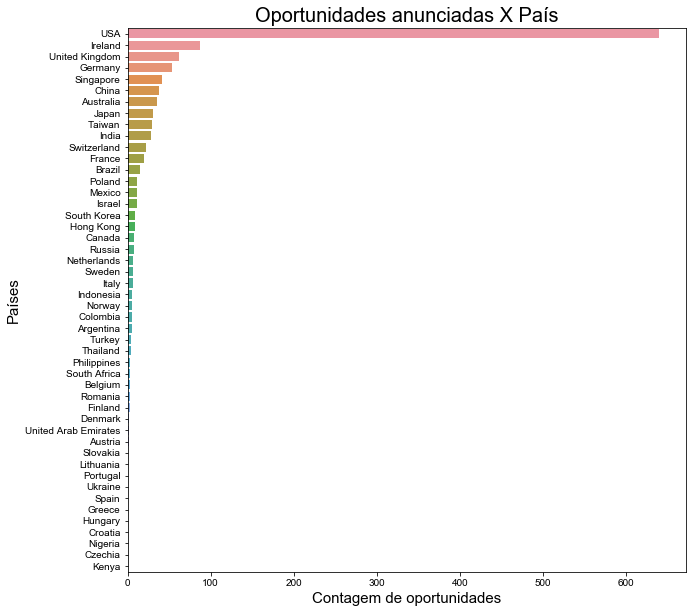

In [16]:
plt.figure(figsize=(10,10))
plt.title('Oportunidades anunciadas X País', fontsize=20)
sns.countplot(y='Countries', data=df, order = df['Countries'].value_counts().index)
plt.xlabel('Contagem de oportunidades', fontsize=15)
plt.ylabel('Países', fontsize=15)
sns.set_style("whitegrid");

Talvez seja interessante registrar os dados agregados de oportunidades por país em forma de tabela:

In [17]:
# Pretendo agrupar os dados por país e utilizar qualquer coluna apenas para criar a contagem das vagas existentes.
# No caso, selecionarei a coluna 'Company' para fazer a contagem. Posteriormente esta coluna (que conterá a contagem de vagas)
# será renomeada para 'Oportunidades', deixando a interpretação mais intuitiva.

oportunidade_pais = df.groupby(['Countries']).agg({'Company': 'count'}).sort_values(by='Company', ascending=False).reset_index()
oportunidade_pais.columns = ['Countries', 'Oportunidades']
oportunidade_pais = oportunidade_pais.set_index('Countries')

# Vamos aproveitar e ver o número de vagas dos 10 países que mais oferecem vagas
oportunidade_pais.head(13)

Oportunidades
Countries                    
USA                       640
Ireland                    87
United Kingdom             62
Germany                    54
Singapore                  41
China                      38
Australia                  35
Japan                      31
Taiwan                     30
India                      28
Switzerland                22
France                     20
Brazil                     15

In [18]:
# Alguns dados sobre a distribuição de vagas por país:
oportunidade_pais.describe()

Oportunidades
count      48.000000
mean       26.041667
std        92.307063
min         1.000000
25%         2.000000
50%         5.000000
75%        16.250000
max       640.000000

In [19]:
# São 48 países em nossa lista.
# A média de oportunidades é de 26 vagas, mas a mediana é de 5 vagas apenas.

### Vamos eliminar os EUA ('USA') da visualização para entrarmos na escala dos demais países: 


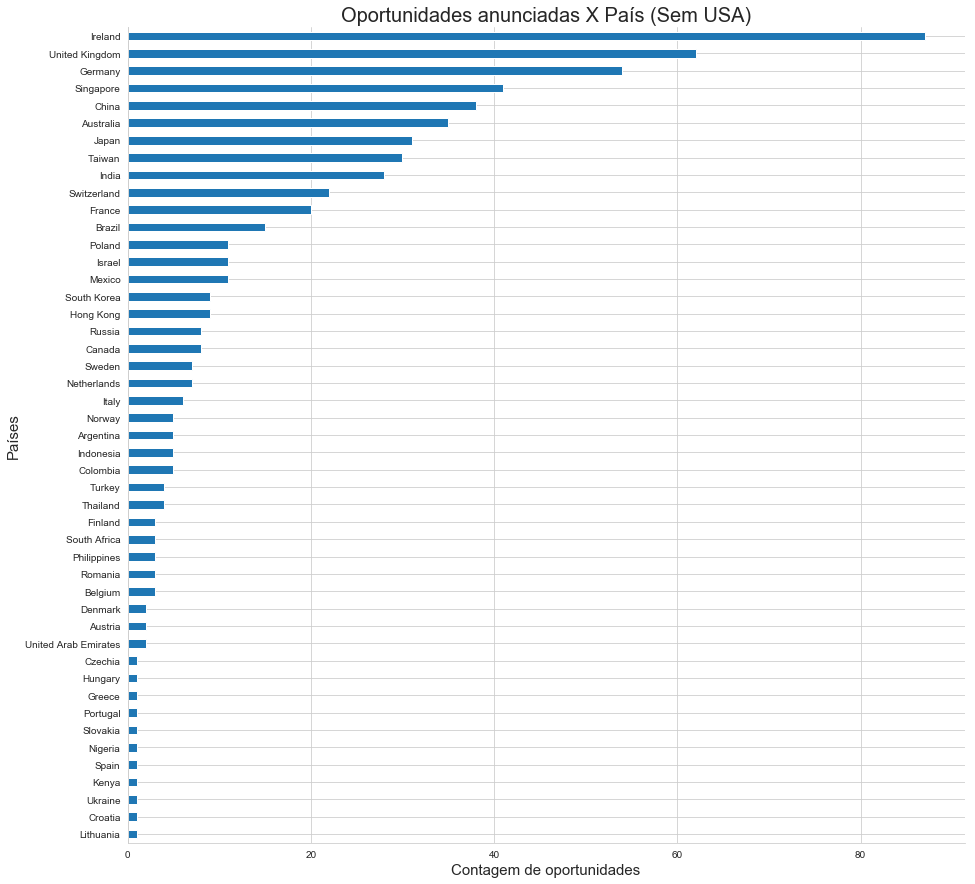

In [20]:
oportunidade_pais.iloc[1:].sort_values(by='Oportunidades', ascending=True).plot(kind='barh', figsize=(15,15), legend=None)
plt.title('Oportunidades anunciadas X País (Sem USA)', fontsize=20)
plt.xlabel('Contagem de oportunidades', fontsize=15)
plt.ylabel('Países', fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);

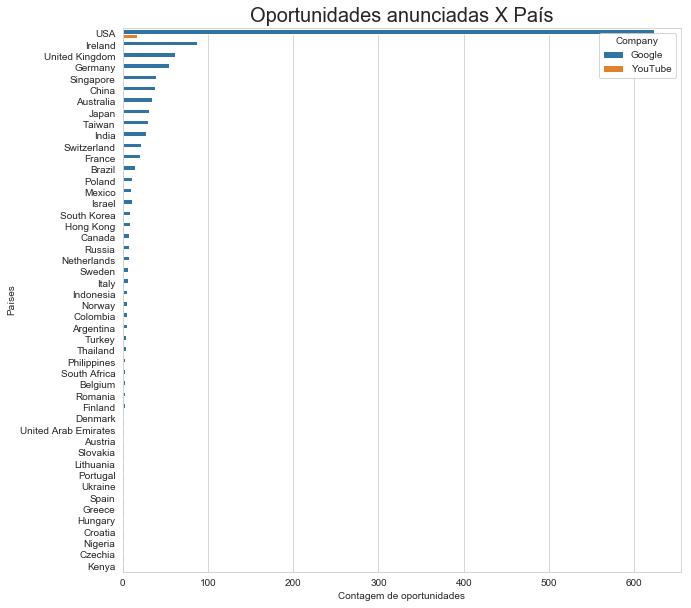

In [21]:
# Apenas para criar a distinção entre vagas para o Youtube e vagas para o Google.
plt.figure(figsize=(10,10))
plt.title('Oportunidades anunciadas X País', fontsize=20)
sns.countplot(y='Countries', data=df, order = df['Countries'].value_counts().index, hue='Company')
plt.xlabel('Contagem de oportunidades')
plt.ylabel('Países');

In [22]:
# Em análises futuras poderíamos agregar estes dados em falantes de lingua inglesa e não inglesa, 
#  ou poderíamos agrupar por continentes, por exemplo.

-------------------------------------------------------------

# Vagas anunciadas para o Brasil:

In [23]:
vagas_brasil = df[df['Countries']=='Brazil']['Countries'].value_counts()[0]

print('Temos {} vagas anunciadas no Brasil'.format(vagas_brasil))

Temos 15 vagas anunciadas no Brasil


#### Em que categorias e títulos tais vagas estaríam distribuídas?

In [24]:
# 1) Restringirei nossos dados aos referentes ao Brasil: df[df['Countries']=='Brazil'
# 2) Farei uma tabela pivotante em que constem como colunas 'Category' e 'Title'.
# 3) Usarei qualquer outra coluna, no caso Company, apenas para fazer uma contagem de elementos.
# 4) Vou ajustá-la de forma a poder renomear as colunas na célula seguinte, deixando a interpretação mais intuitiva.

oportunidades_brasil = pd.pivot_table(data=df[df['Countries']=='Brazil'], 
               index=['Category','Title'], 
               columns=['Countries'], 
               aggfunc={'Company':'count'}).reset_index()

In [25]:
oportunidades_brasil.columns = ['Categoria', 'Título', 'Número de Oportunidades']
oportunidades_brasil

Categoria  \
0            Business Strategy   
1            Business Strategy   
2                      Finance   
3                      Finance   
4                 Partnerships   
5            People Operations   
6   Sales & Account Management   
7   Sales & Account Management   
8   Sales & Account Management   
9         Software Engineering   
10         Technical Solutions   

                                               Título  Número de Oportunidades  
0   Agency Go-to-Market and Business Analytics Man...                        1  
1                        Head of Go-To-Market, Brazil                        1  
2                        Business Intern 2018, Brazil                        4  
3   Payroll Operations Controller, Financial Opera...                        1  
4   Strategic Partner Manager, Product Partnership...                        1  
5                        Staffing Programs Specialist                        1  
6   Account Executive, Mid Market Sales, Google Ma...                        1  
7            Account Strategist (English, Portuguese)                        1  
8   Account Strategist, Google Marketing Solutions...                        1  
9                         Software Engineer (English)                        2  
10  Customer Engineer, Google Cloud Platform (Port...                        1

### Partindo para uma noção mais visual de como as vagas se distribuem no Brasil:

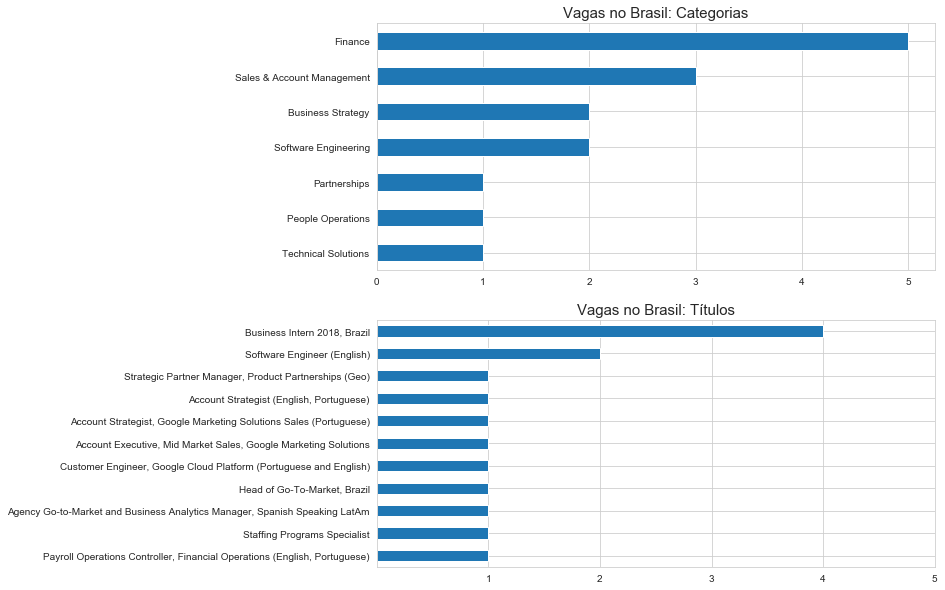

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.title('Vagas no Brasil: Títulos', fontsize=15)
df[df['Countries']=='Brazil']['Title'].value_counts(ascending=True).plot(kind='barh')
plt.xticks([1,2,3,4,5])
plt.subplot(2,1,1)
plt.title('Vagas no Brasil: Categorias', fontsize=15)
df[df['Countries']=='Brazil']['Category'].value_counts(ascending=True).plot(kind='barh');


----------------------------------
# Categorias mais frequentes das vagas globais:

In [27]:
df['Category'].unique()

array(['Program Management', 'Manufacturing & Supply Chain',
       'Technical Solutions', 'Developer Relations',
       'Hardware Engineering', 'Partnerships',
       'Product & Customer Support', 'Software Engineering',
       'Data Center & Network', 'Business Strategy', 'Technical Writing',
       'Technical Infrastructure', 'IT & Data Management',
       'Marketing & Communications', 'Network Engineering',
       'Sales & Account Management', 'Sales Operations', 'Finance',
       'Legal & Government Relations', 'Administrative',
       'User Experience & Design', 'People Operations',
       'Real Estate & Workplace Services'], dtype=object)

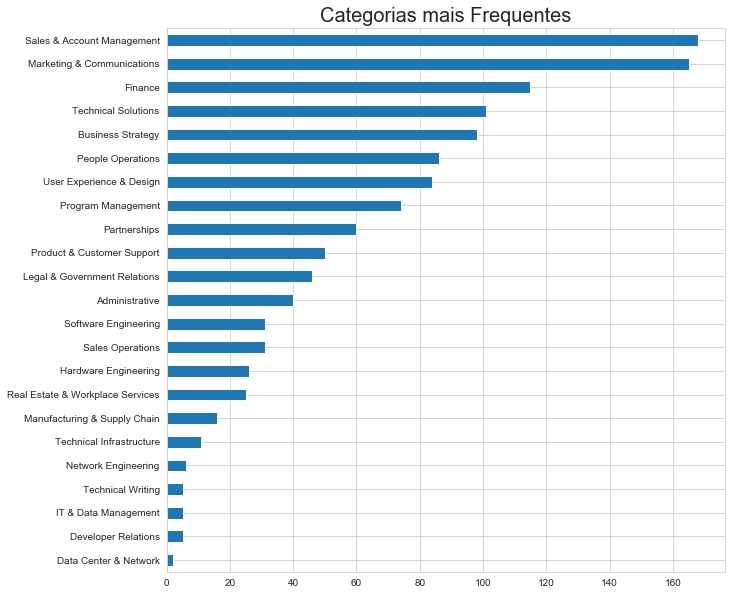

In [28]:
plt.figure(figsize=(10,10))
plt.title('Categorias mais Frequentes',  fontsize=20)
df['Category'].value_counts(ascending=True).plot(kind='barh');

In [29]:
df['Category'].value_counts(ascending=False)

Sales & Account Management          168
Marketing & Communications          165
Finance                             115
Technical Solutions                 101
Business Strategy                    98
People Operations                    86
User Experience & Design             84
Program Management                   74
Partnerships                         60
Product & Customer Support           50
Legal & Government Relations         46
Administrative                       40
Software Engineering                 31
Sales Operations                     31
Hardware Engineering                 26
Real Estate & Workplace Services     25
Manufacturing & Supply Chain         16
Technical Infrastructure             11
Network Engineering                   6
Technical Writing                     5
IT & Data Management                  5
Developer Relations                   5
Data Center & Network                 2
Name: Category, dtype: int64

As principais oportunidades são relacionadas a vendas e marketing e, em um terceiro lugar mais distante, finanças.

--------------------------------------------------------------------

# Qualificação mínima:

### Estudaremos a qualificação mínima quanto a:
1) Grau de formação;

2) Anos de experiência;

3) Habilidades relevantes: linguagem de programação, uso de ferramentas, etc;

In [30]:
df['Minimum Qualifications'].unique()

array(['BA/BS degree or equivalent practical experience.\n3 years of experience in program and/or project management in cloud computing, enterprise software and/or marketing technologies.',
       'BS degree in an Engineering discipline or equivalent practical experience.\n7 years of experience in Cable/Connector Design or Manufacturing in an NPI role.\nExperience working with Interconnect Engineering and Product Design (PD)/Mechanical Engineer in developing, manufacturing and testing.\nAbility to speak and write in English and Mandarin fluently and idiomatically.',
       'Bachelor’s degree in Business, Economics, Statistics, Operations Research or related analytical field, or equivalent practical experience.\n2 years of work experience in business analysis.\n1 year of experience with statistical modeling, forecasting or machine learning. Experience with R, SAS or Python.\n1 year of experience developing and manipulating large datasets.',
       'BA/BS degree in Computer Science or eq

In [31]:
df['Minimum Qualifications'].nunique()/df['Minimum Qualifications'].count() #65% de descrições únicas.

0.6529126213592233

Criarei mais uma coluna relacionada ao grau da formação mínima exigida.

Existe um certo padrão entre as descrições de 'Minimum Qualifications' em que a descrição do nível desejado precede a palavra degree. Faremos uso deste padrão na criação de uma nova coluna a seguir:

In [32]:
df['MQ_degree'] = df['Minimum Qualifications'].dropna().apply(lambda x: x.lower().split('degree')[0].strip())

In [33]:
df['MQ_degree'].nunique()

117

In [34]:
def find_degree(string):
    if 'ba/bs' in string:
        string = 'ba/bs'
        
    if ' ba ' in string:
        string = 'ba'
    
    if ' bs ' in string:
        string = 'bs'
    
    
    if 'phd' in string:
        string = 'phd'
        
    if 'ph.d' in string:
        string = 'phd'
        
    if 'jd' in string:
        string = 'jd'
    if 'j.d.' in string:
        string = 'jd'
    if 'ms' in string:
        string = 'ms'
    if 'master' in string:
        string = 'ms'
    if 'bachelor' in string:
        string = 'bachelor'
    if 'mba' in string:
        string = 'mba'
    if 'major' in string:
        string = 'major'
    return string

df['MQ_degree'] = df['MQ_degree'].dropna().apply(find_degree)

In [35]:
df['MQ_degree'].nunique()

59

In [36]:
df['MQ_degree'].unique()

array(['ba/bs', 'bs', 'bachelor', nan, 'phd',
       '7 years of experience in a technical training role.\n5 years of experience in a management role.\nexperience in managing team of technical trainers.',
       '5 years of experience in supply chain operations across technical and/or networking fields.\nexperience in a program management role, leading data management solutions.',
       'experience managing analytics solutions.\nexperience managing client expectations, requirements. experience in conflict resolution.\nability to speak and write in english fluently and idiomatically.',
       'ms',
       '5 years of experience in a training business and/or as a channel manager.\nexperience with business development and experience in identifying, recruiting and managing partners and delivering go-to-market strategies.\nwillingness to travel across the americas (north america and latin america).',
       'コンピュータ サイエンスまたは関連する技術分野で学士号を取得していること（関連職種での実務経験でも可）\nc、c++ を使用したプログラミング経験\nドライバや、l

In [37]:
df

Company                                              Title  \
0      Google                       Google Cloud Program Manager   
1      Google  Supplier Development Engineer (SDE), Cable/Con...   
2      Google  Data Analyst, Product and Tools Operations, Go...   
3      Google            Developer Advocate, Partner Engineering   
4      Google     Program Manager, Audio Visual (AV) Deployments   
5      Google  Associate Account Strategist (Czech/Slovak), G...   
6      Google  Supplier Development Engineer, Camera, Consume...   
7      Google  Strategic Technology Partner Manager, Healthca...   
8      Google    Manufacturing Business Manager, Google Hardware   
9      Google  Solutions Architect, Healthcare and Life Scien...   
10     Google                    Data Analyst, Consumer Hardware   
11     Google              Partner Onboarding Manager (Americas)   
12     Google  Associate Account Strategist (Ukrainian), GMS ...   
13     Google                  Survey Lead, Google Cloud Support   
14     Google  Solution Architect, Google Cloud Platform (Api...   
15     Google                        Manufacturing Test Engineer   
16     Google  Machine Learning Product Specialist, Google Cl...   
17     Google  Software Engineering Manager, Cloud Storage, S...   
18     Google  Global Supply Chain Manager, Display/Touch, Co...   
19     Google        Technical Program Manager, ASIC Development   
20     Google                  Quantitative Analyst, Ads Quality   
21     Google  Software Engineer Manager, Tools and Infrastru...   
22     Google                      Head of Professional Services   
23     Google                  Survey Lead, Google Cloud Support   
24     Google            Technical Trainer Manager, Google Cloud   
25     Google               Partner Sales Engineer, Google Cloud   
26     Google  Technical Solutions Engineer, Chrome and Andro...   
27     Google      Program Manager, Supply Chain Data Management   
28     Google  Machine Learning Product Specialist, Google Cl...   
29     Google          Head of Partner Engineering, Google Cloud   
...       ...                                                ...   
1220   Google  Change Management Specialist, Google Professio...   
1221   Google         Live Show Producer, Events and Experiences   
1222   Google       Cluster Manager, Security (English, Chinese)   
1223   Google       Cluster Manager, Security (English, Chinese)   
1224   Google              Campus Manager (English and Mandarin)   
1225   Google                Real Estate Portfolio Administrator   
1226  YouTube  Real Estate and Workplace Services (REWS) Busi...   
1227   Google          Communications Analyst, Physical Security   
1228   Google   Global REWS Marketing and Communications Manager   
1229   Google  Technical Program Manager, Executive and Event...   
1230   Google                  Project Manager, Security Systems   
1231   Google       Cluster Manager, Security (English, Chinese)   
1232   Google                                Global Investigator   
1233   Google         Real Estate District Development Executive   
1234   Google                                Global Investigator   
1235   Google                          Physical Security Manager   
1236   Google                     Food Service Manager, Americas   
1237   Google                     Food Service Manager, Americas   
1238   Google  Program Manager, Third Party Risk Management (...   
1239   Google              Real Estate Portfolio Management Lead   
1240   Google            Visual Designer, Events and Experiences   
1241   Google                  Real Estate Development Executive   
1242   Google                          Physical Security Manager   
1243   Google       Cluster Manager, Security (English, Chinese)   
1244   Google  Protective Services Specialist, Executive Prot...   
1245   Google                                Global Investigator   
1246   Google                            Campus Security Manag

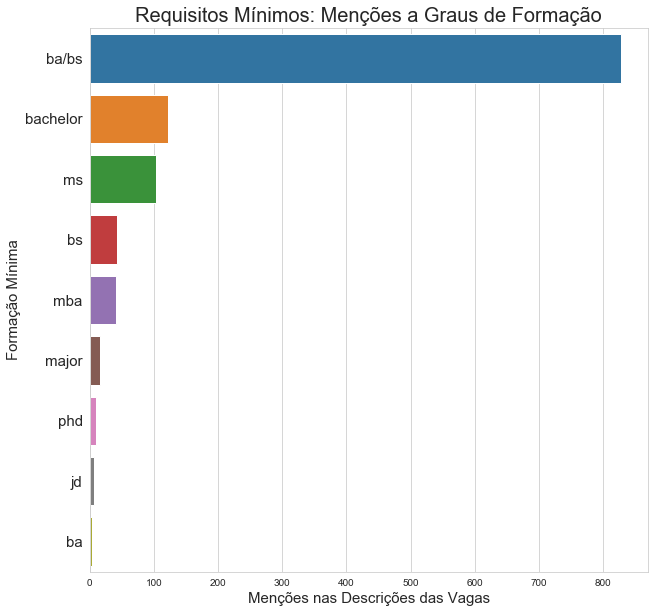

In [38]:
# selecionando apenas os títulos principais para criar uma visualização
masked = df[df['MQ_degree'].isin(['ba/bs', 'ba','bs', 'bachelor', 'ms', 'jd', 'phd', 'mba', 'major'])]


plt.figure(figsize=(10,10))
plt.title('Requisitos Mínimos: Menções a Graus de Formação', fontsize=20)
sns.countplot(y='MQ_degree', data=df, order = masked['MQ_degree'].value_counts().index )
plt.yticks(fontsize=15)
plt.xticks(fontsize=10)
plt.xlabel('Menções nas Descrições das Vagas', fontsize=15)
plt.ylabel('Formação Mínima', fontsize=15);

# Um detalhe importante é que o gráfico a seguir separa as menções conjuntas a BA/BS de ocorrências isoladas de BA e BS. 
# Manterei a visualização desta forma apenas para registrar a indiferença quanto a BA (Bacharelado em Artes) e BS (Bacharelado em Ciências)
# por parte do recrutador.

Ter um bacharelado é, definitivamente, um requisito importante.

A principal descrição mais frequente refere-se a 'BA/BS', ou melhor, Bacharelado em Artes ou Bacharelado em Ciências.

A segunda descrição consta simplesmente como Bacharelado. Sendo seguido por Mestrado, MBA, Major, PHD e JD (Juris Doctor).

Quanto aos 'degrees' usei como referência o site https://study.com/different_degrees.html para ter um entendimento mais profundo.

## Buscarei brevemente entender como a exigência quanto a graus de formação se distribui em relação às categorias das vagas:

In [39]:
grau_de_formação = pd.pivot_table(data=df[df['MQ_degree'].isin(['ba/bs','ba','bs','bachelor','ms','jd','phd','mba','major'])],
                                  index=['Category'], 
                                  columns=['MQ_degree'], 
                                  aggfunc={'Company':'count'}).reset_index()

In [40]:
grau_de_formação.fillna(value=0, inplace=True) # Para fazer cálculos, substituirei NaN por 0

In [41]:
grau_de_formação.head()

Category Company                                       \
MQ_degree                             ba ba/bs bachelor   bs   jd major   mba   
0                 Administrative     0.0  10.0      0.0  0.0  0.0   0.0   2.0   
1              Business Strategy     0.0  46.0      3.0  0.0  0.0   0.0  37.0   
2          Data Center & Network     0.0   0.0      0.0  1.0  0.0   0.0   0.0   
3            Developer Relations     0.0   5.0      0.0  0.0  0.0   0.0   0.0   
4                        Finance     0.0  79.0      6.0  0.0  0.0  16.0   0.0   

                      
MQ_degree    ms  phd  
0          28.0  0.0  
1           6.0  2.0  
2           0.0  0.0  
3           0.0  0.0  
4           6.0  0.0

In [42]:
grau_de_formação.columns

MultiIndex(levels=[['Company', 'Category'], ['ba', 'ba/bs', 'bachelor', 'bs', 'jd', 'major', 'mba', 'ms', 'phd', '']],
           codes=[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [9, 0, 1, 2, 3, 4, 5, 6, 7, 8]],
           names=[None, 'MQ_degree'])

In [43]:
grau_de_formação.columns = grau_de_formação.columns.droplevel() #retirando um dos níveis de coluna, para facilitar a manipulação e compreensão.

In [44]:
grau_de_formação.head()

MQ_degree                          ba  ba/bs  bachelor   bs   jd  major   mba  \
0                 Administrative  0.0   10.0       0.0  0.0  0.0    0.0   2.0   
1              Business Strategy  0.0   46.0       3.0  0.0  0.0    0.0  37.0   
2          Data Center & Network  0.0    0.0       0.0  1.0  0.0    0.0   0.0   
3            Developer Relations  0.0    5.0       0.0  0.0  0.0    0.0   0.0   
4                        Finance  0.0   79.0       6.0  0.0  0.0   16.0   0.0   

MQ_degree    ms  phd  
0          28.0  0.0  
1           6.0  2.0  
2           0.0  0.0  
3           0.0  0.0  
4           6.0  0.0

In [45]:
# O que farei agora é desmembrar a menção a 'ba/bs' em categorias 'ba' e 'bs' e retirarei a menção dupla.
# Vale lembrar que, com isso, cada vaga poderá ter mais de um 'representante' em grau de formação desejado.
grau_de_formação['ba'] = grau_de_formação['ba'] + grau_de_formação['ba/bs']
grau_de_formação['bs'] = grau_de_formação['bs'] + grau_de_formação['ba/bs']
grau_de_formação.drop(columns=['ba/bs'], inplace=True)

In [46]:
# Agora criarei uma coluna para computar o grau de menções feitos ao grau de formação para cada categoria.
grau_de_formação['totais_mencionados'] =  grau_de_formação['ba'] + grau_de_formação['bs'] + grau_de_formação['bachelor'] + grau_de_formação['jd'] + grau_de_formação['major'] + grau_de_formação['mba'] + grau_de_formação['ms'] + grau_de_formação['phd']

In [47]:
# Finalmente, um registro em tabela dos graus de formação exigidos:
grau_de_formação.sort_values(by='totais_mencionados', ascending=False)

MQ_degree                                       ba  bachelor     bs   jd  \
16               Sales & Account Management  138.0      20.0  140.0  0.0   
9                Marketing & Communications  116.0       8.0  114.0  0.0   
4                                   Finance   79.0       6.0   79.0  0.0   
12                        People Operations   81.0       3.0   81.0  0.0   
20                      Technical Solutions   68.0      23.0   73.0  0.0   
1                         Business Strategy   46.0       3.0   46.0  0.0   
22                 User Experience & Design   56.0      10.0   57.0  0.0   
14                       Program Management   40.0      16.0   44.0  0.0   
11                             Partnerships   43.0      11.0   45.0  0.0   
13               Product & Customer Support   35.0       6.0   36.0  0.0   
17                         Sales Operations   30.0       1.0   30.0  0.0   
7              Legal & Government Relations   24.0       3.0   24.0  7.0   
0                            Administrative   10.0       0.0   10.0  0.0   
15         Real Estate & Workplace Services   22.0       3.0   22.0  0.0   
18                     Software Engineering   10.0       0.0   17.0  0.0   
5                      Hardware Engineering    6.0       5.0   14.0  0.0   
8              Manufacturing & Supply Chain    9.0       3.0   11.0  0.0   
19                 Technical Infrastructure    4.0       1.0    9.0  0.0   
10                      Network Engineering    4.0       0.0    6.0  0.0   
3                       Developer Relations    5.0       0.0    5.0  0.0   
21                        Technical Writing    5.0       0.0    5.0  0.0   
6                      IT & Data Management    0.0       0.0    2.0  0.0   
2                     Data Center & Network    0.0       0.0    1.0  0.0   

MQ_degree  major   mba    ms  phd  totais_mencionados  
16           0.0   0.0   3.0  0.0               301.0  
9            0.0   0.0  38.0  0.0               276.0  
4           16.0   0.0   6.0  0.0               186.0  
12           0.0   0.0   0.0  0.0               165.0  
20           0.0   0.0   0.0  0.0               164.0  
1            0.0  37.0   6.0  2.0               140.0  
22           0.0   0.0   9.0  0.0               132.0  
14           0.0   0.0   3.0  0.0               103.0  
11           0.0   2.0   0.0  0.0               101.0  
13           0.0   0.0   3.0  5.0                85.0  
17           0.0   0.0   0.0  0.0                61.0  
7            0.0   0.0   0.0  0.0                58.0  
0            0.0   2.0  28.0  0.0                50.0  
15           0.0   0.0   0.0  0.0                47.0  
18           0.0   0.0   4.0  0.0                31.0  
5            0.0   0.0   2.0  0.0                27.0  
8            0.0   0.0   0.0  0.0                23.0  
19           0.0   0.0   1.0  0.0                15.0  
10           0.0   0.0   0.0  0.0                10.0  
3            0.0   0.0   0.0  0.0                10.0  
21           0.0   0.0   0.0  0.0                10.0  
6            0.0   0.0   0.0  3.0                 5.0  
2            0.0   0.0   0.0  0.0                 1.0

In [48]:
tabela_grau_formacao = pd.DataFrame(grau_de_formação.drop(columns=['totais_mencionados']).sum()).reset_index().iloc[1:8]

In [49]:
tabela_grau_formacao.set_index('MQ_degree', drop=True, inplace=True)


In [50]:
tabela_grau_formacao.columns = ['contagem']
tabela_grau_formacao.sort_values(by='contagem', ascending=False)

contagem
MQ_degree         
bs             871
ba             831
bachelor       122
ms             103
mba             41
major           16
jd               7

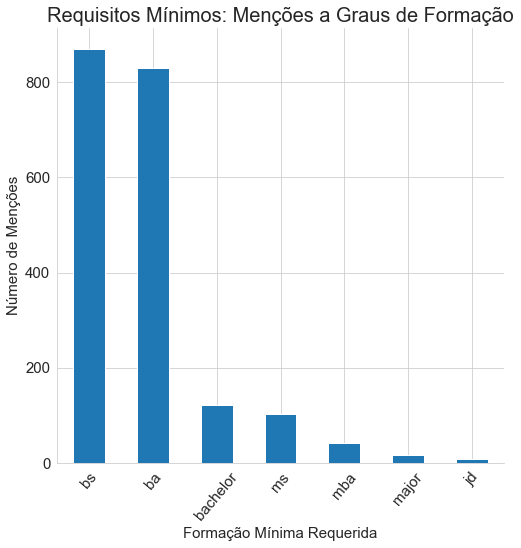

In [51]:
tabela_grau_formacao.sort_values(by='contagem', ascending=False).plot(kind='bar', figsize=(8,8), legend=None)
plt.title('Requisitos Mínimos: Menções a Graus de Formação', fontsize=20)
plt.ylabel('Número de Menções', fontsize=15)
plt.xlabel('Formação Mínima Requerida', fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, rotation=50);

# Lembremos que há vagas que mencionam mais de um grau, e estamos contando as menções de forma que estão inflando a quantidade de oportunidades.

### ANOS DE EXPERIÊNCIA: Passemos a verificar a quantidade de anos de experiência exigidos em cada vaga.

In [52]:
# Criarei mais uma coluna que registre o número de anos de experiência exigido pela vaga.
# Geralmente a menção a anos de experiência vem no formado: um ou mais algarismos + 'years'.
# Farei uso deste padrão e utilizarei regex para capturar todos os casos.
# Obs: verifiquei que nem todas as menções a anos sugerem necessariamente anos de experiência (em um caso, por exemplo, 
# refere-se à idade de crianças). Ainda assim, o padrão é suficientemente geral para que eu aceite o risco de errar poucas 
# vezes e tenha que refinar o tratamento mais tarde.

def find_year(string):
    finded = re.findall(r'([0-9]+) years', string) #encontrando descrições no formado: um ou mais algarismos + 'years'. Manterei apenas a parte numérica.
    try: 
        finded = finded[0] #manterei apenas a primeira menção a anos de experiência, considerando que o mais relevante costuma ser mencionado antes
        return finded 
    except:
        return finded

df['Years of Experience'] = df['Minimum Qualifications'].dropna().apply(lambda x: find_year(x)) 

In [53]:
df['Years of Experience'] = df['Years of Experience'].apply(lambda x: int(x) if type(x)==str else 0)
df['Years of Experience']

0        3
1        7
2        2
3        0
4        4
5        0
6       10
7        5
8        5
9        0
10       4
11       5
12       0
13       5
14       0
15       0
16       0
17       0
18       3
19       5
20       0
21       0
22       0
23       5
24       7
25       0
26       0
27       5
28       0
29      10
        ..
1220     2
1221     6
1222    10
1223    10
1224     5
1225     5
1226     5
1227     0
1228    10
1229     7
1230     5
1231    10
1232     4
1233    10
1234     4
1235     0
1236     0
1237     0
1238     7
1239    10
1240     5
1241    10
1242     0
1243    10
1244     5
1245     4
1246     7
1247     8
1248     0
1249     0
Name: Years of Experience, Length: 1250, dtype: int64

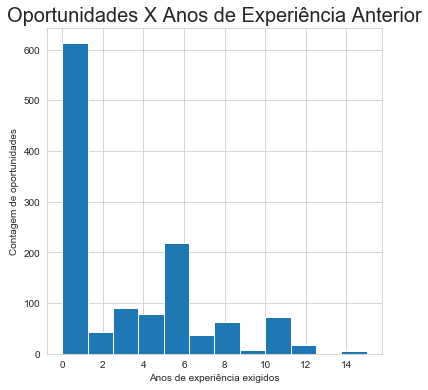

In [54]:
# Histograma: distribuição de anos de experiência mais solicitados



df['Years of Experience'].hist(bins=12, figsize=(6,6))
plt.title('Oportunidades X Anos de Experiência Anterior', fontsize=20)
plt.xlabel('Anos de experiência exigidos')
plt.ylabel('Contagem de oportunidades');

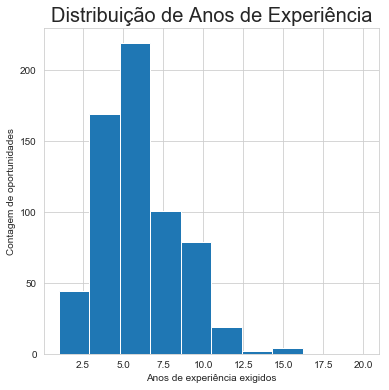

In [55]:
# Histograma: distribuição de anos de experiência mais solicitados (retirando o 0)

df['Years of Experience'].hist(bins=10, range=[1,20], figsize=(6,6)) # Retirando o 0 da visualização
plt.title('Distribuição de Anos de Experiência', fontsize=20)
plt.xlabel('Anos de experiência exigidos')
plt.ylabel('Contagem de oportunidades'); 

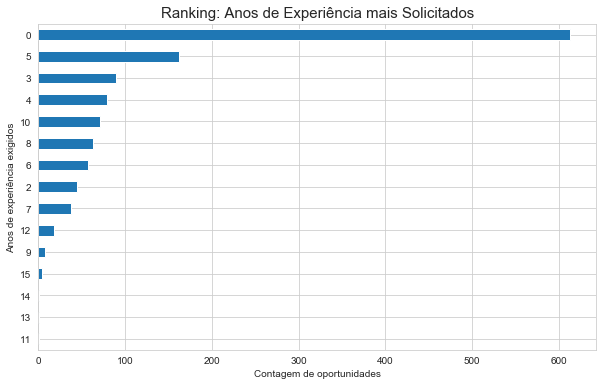

In [56]:
# Em um ranking de anos de experiência mais solicitados:

df['Years of Experience'].value_counts(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title('Ranking: Anos de Experiência mais Solicitados', fontsize=15)
plt.xlabel('Contagem de oportunidades')
plt.ylabel('Anos de experiência exigidos'); 

### Pretendo agora verificar como estes anos de experiência exigidos são distribuídos nas diversas categorias de vagas:

In [57]:
#Primeiro criarei uma lista ordenada dos anos de experiência solicitados:

anos_de_experiência = list((df['Years of Experience'].unique()))

anos_de_experiência.sort()

anos_de_experiência

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

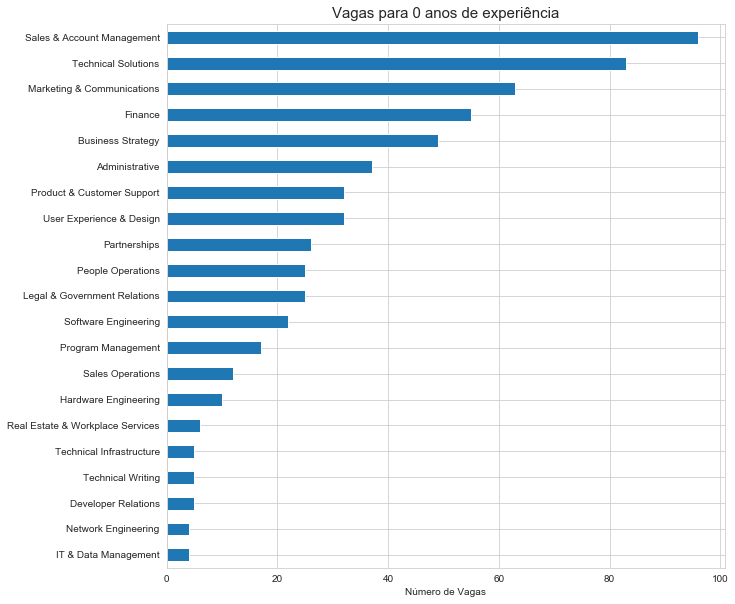

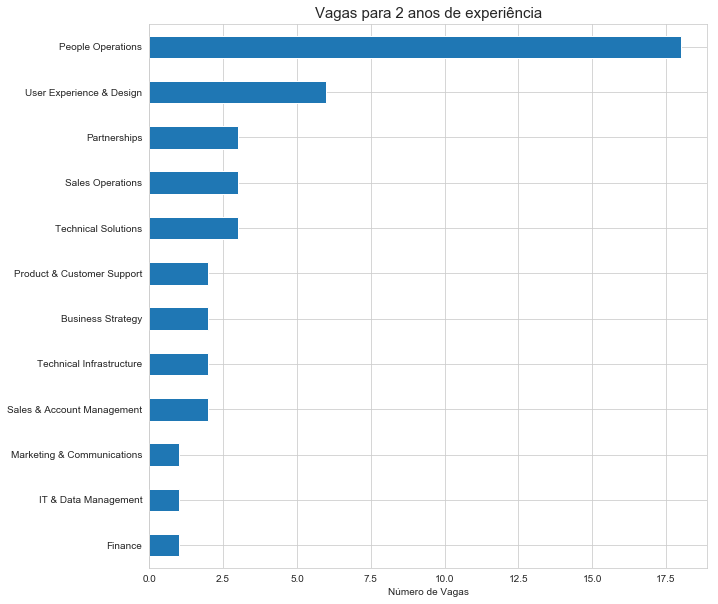

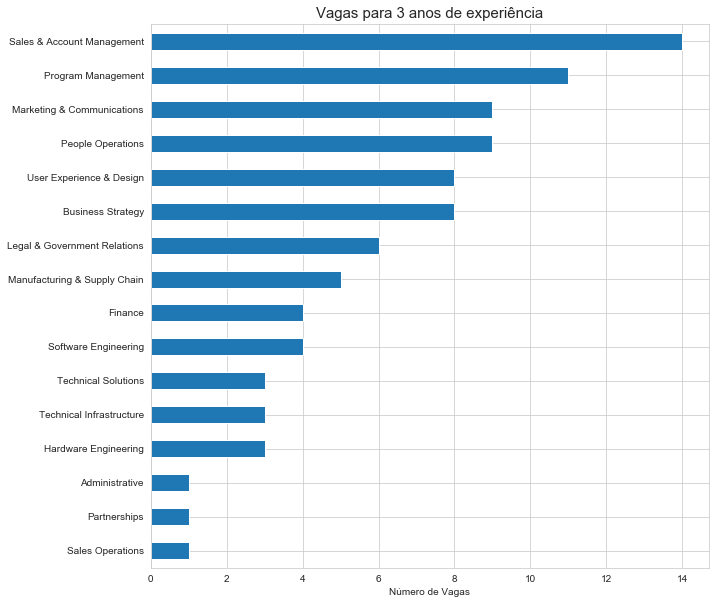

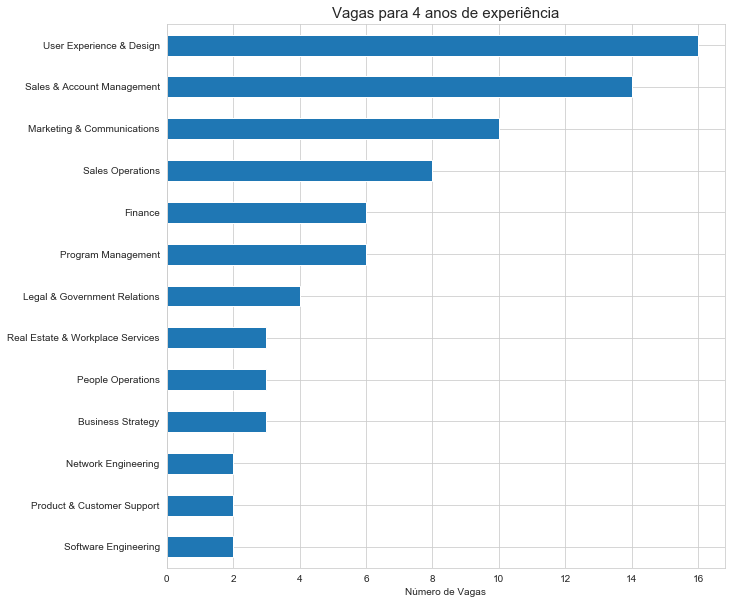

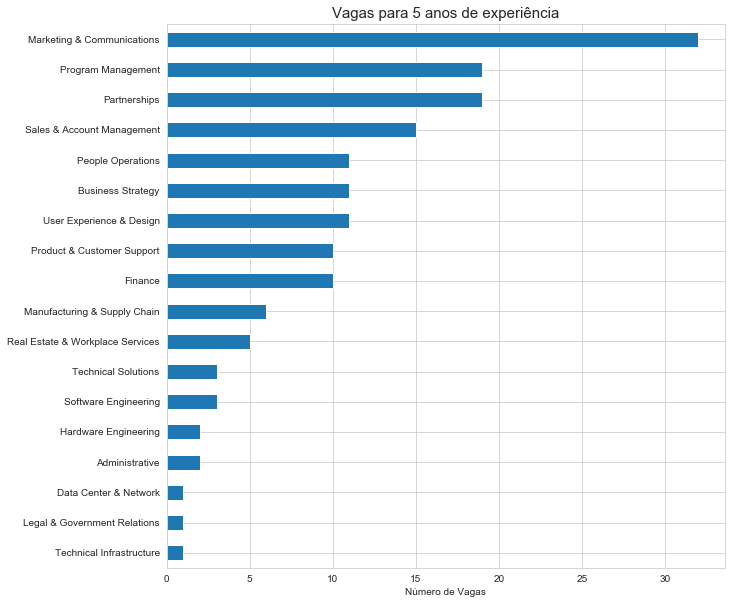

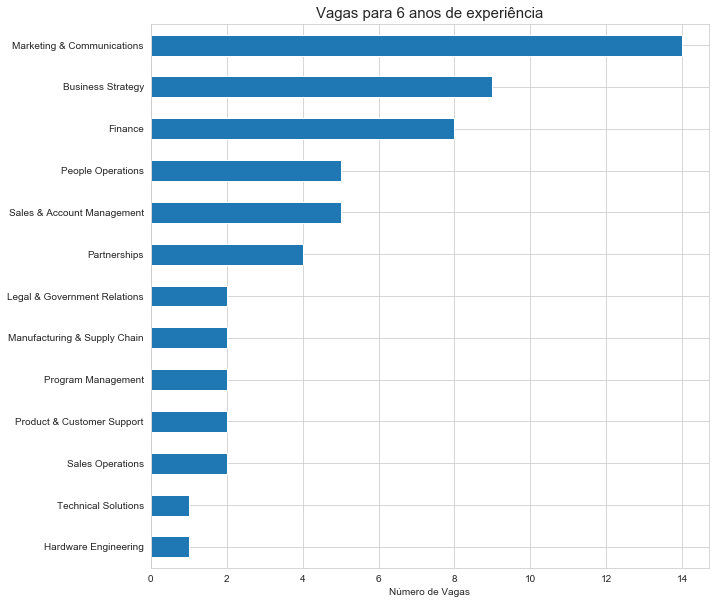

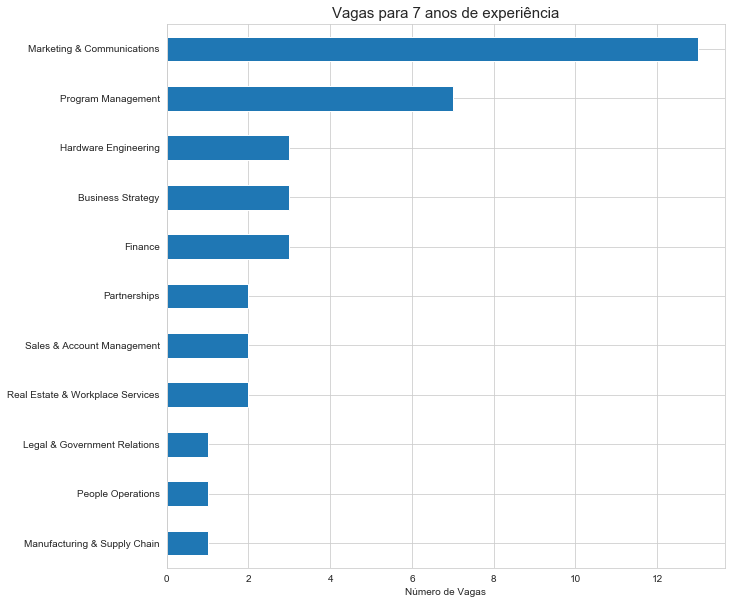

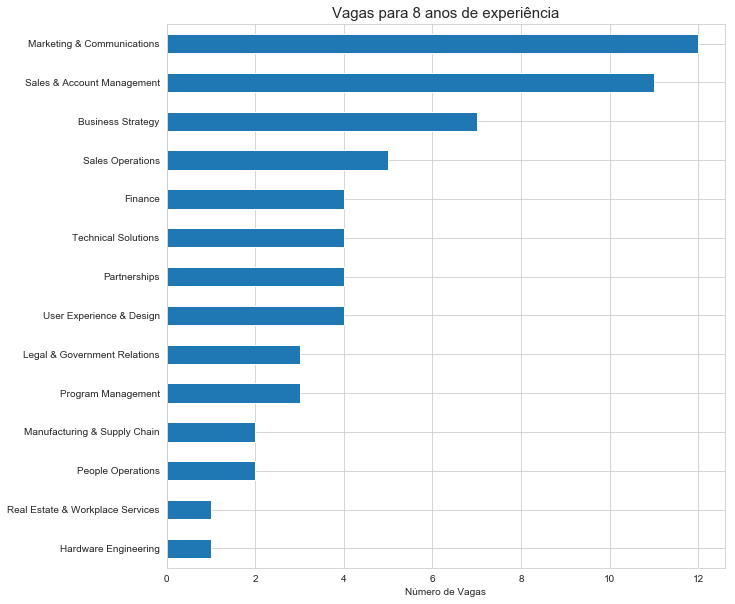

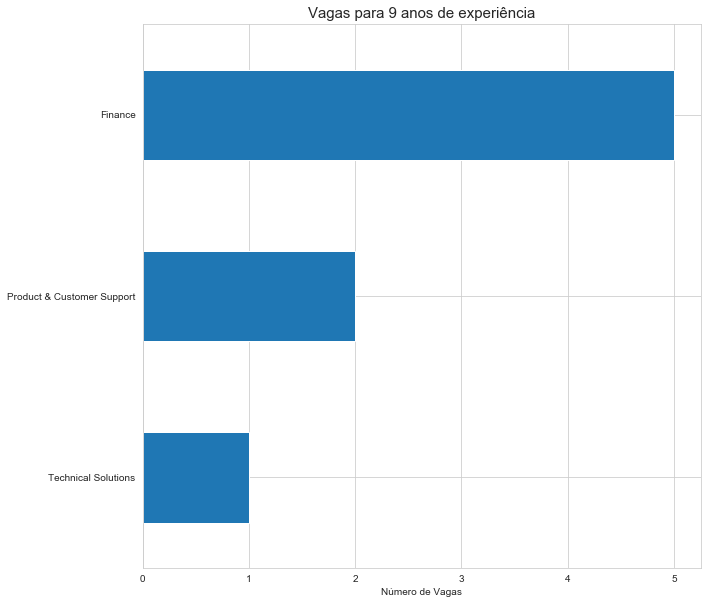

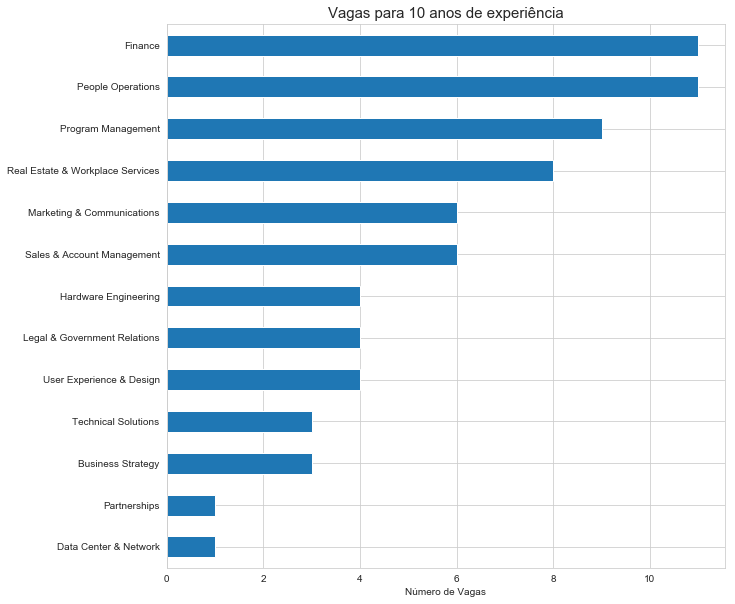

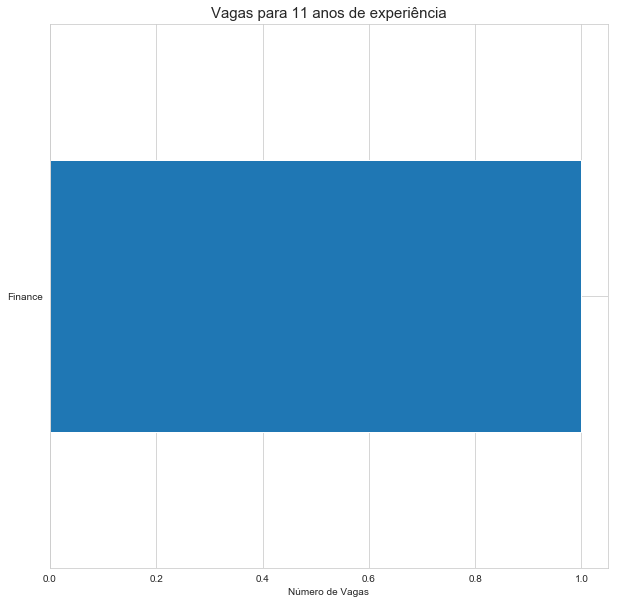

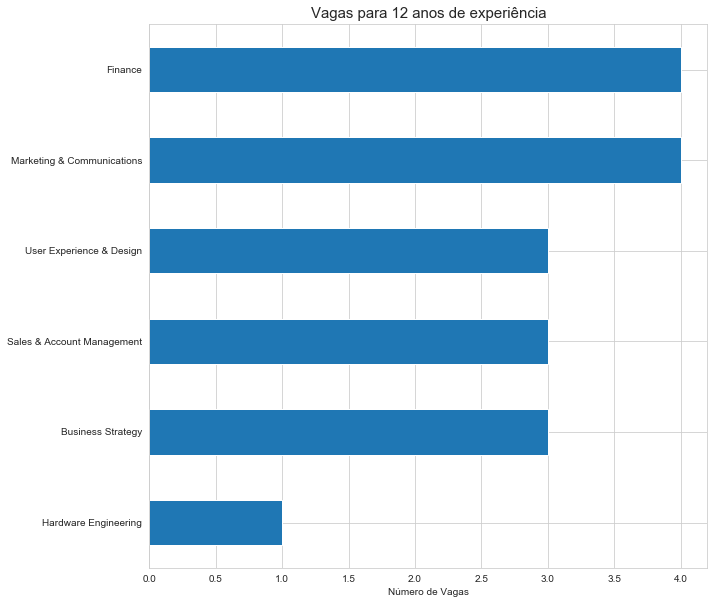

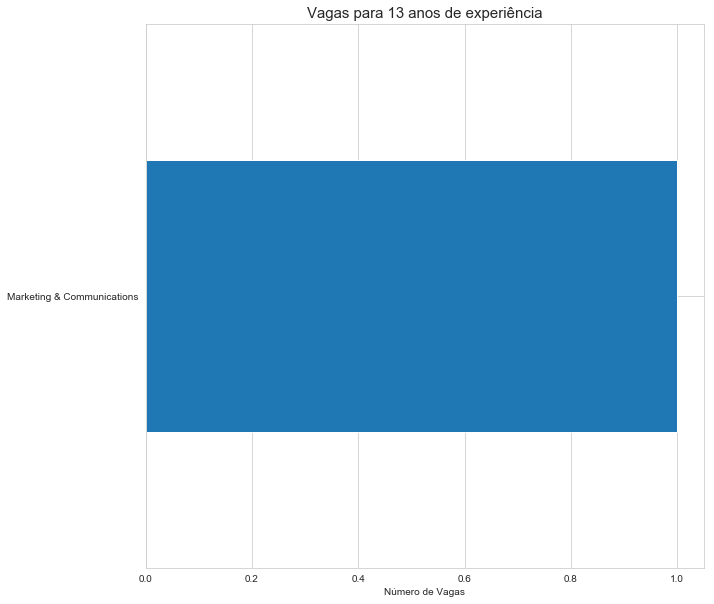

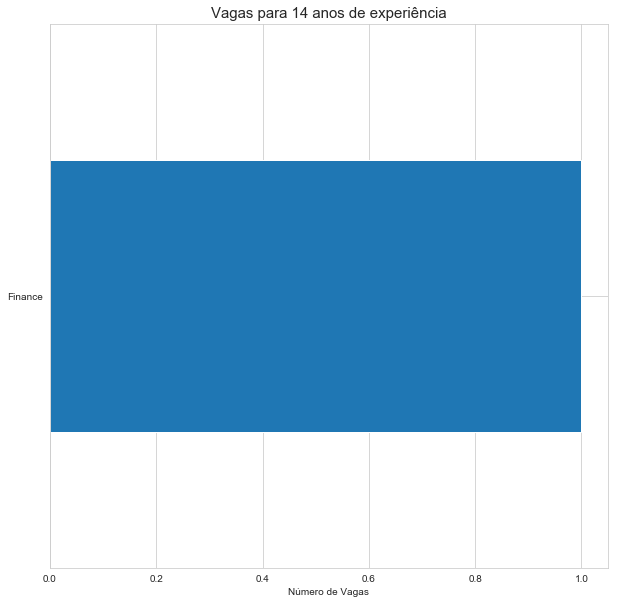

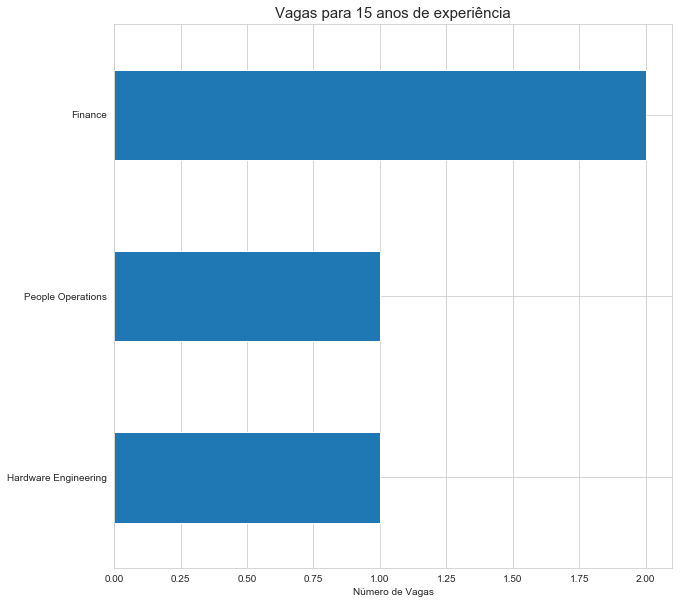

In [58]:
# Agora, para cada ano de experiência mencionado nas vagas, quero saber quantas oportunidades existem em cada categoria de vaga. 

for year in anos_de_experiência:
    
    plt.title('Vagas para {} anos de experiência'.format(year), fontsize=15)
    plt.xlabel('Número de Vagas', fontsize=10)
    df[df['Years of Experience']==year].Category.value_counts(ascending=True).plot(kind='barh', figsize=(10,10))
    plt.show()

### OBS: As oportunidades mudam bastante de acordo com o número de anos de experiência acumulada em determinada área.

#### Nota-se, por exemplo, o grande número de vagas para as áreas de vendas e soluções técnicas que não mencionam experiência prévia.

#### Por outro lado, diversas vagas de Finanças exigem muitos anos de experiência.

### Buscarei ilustrar estes pontos com um gráfico abaixo:

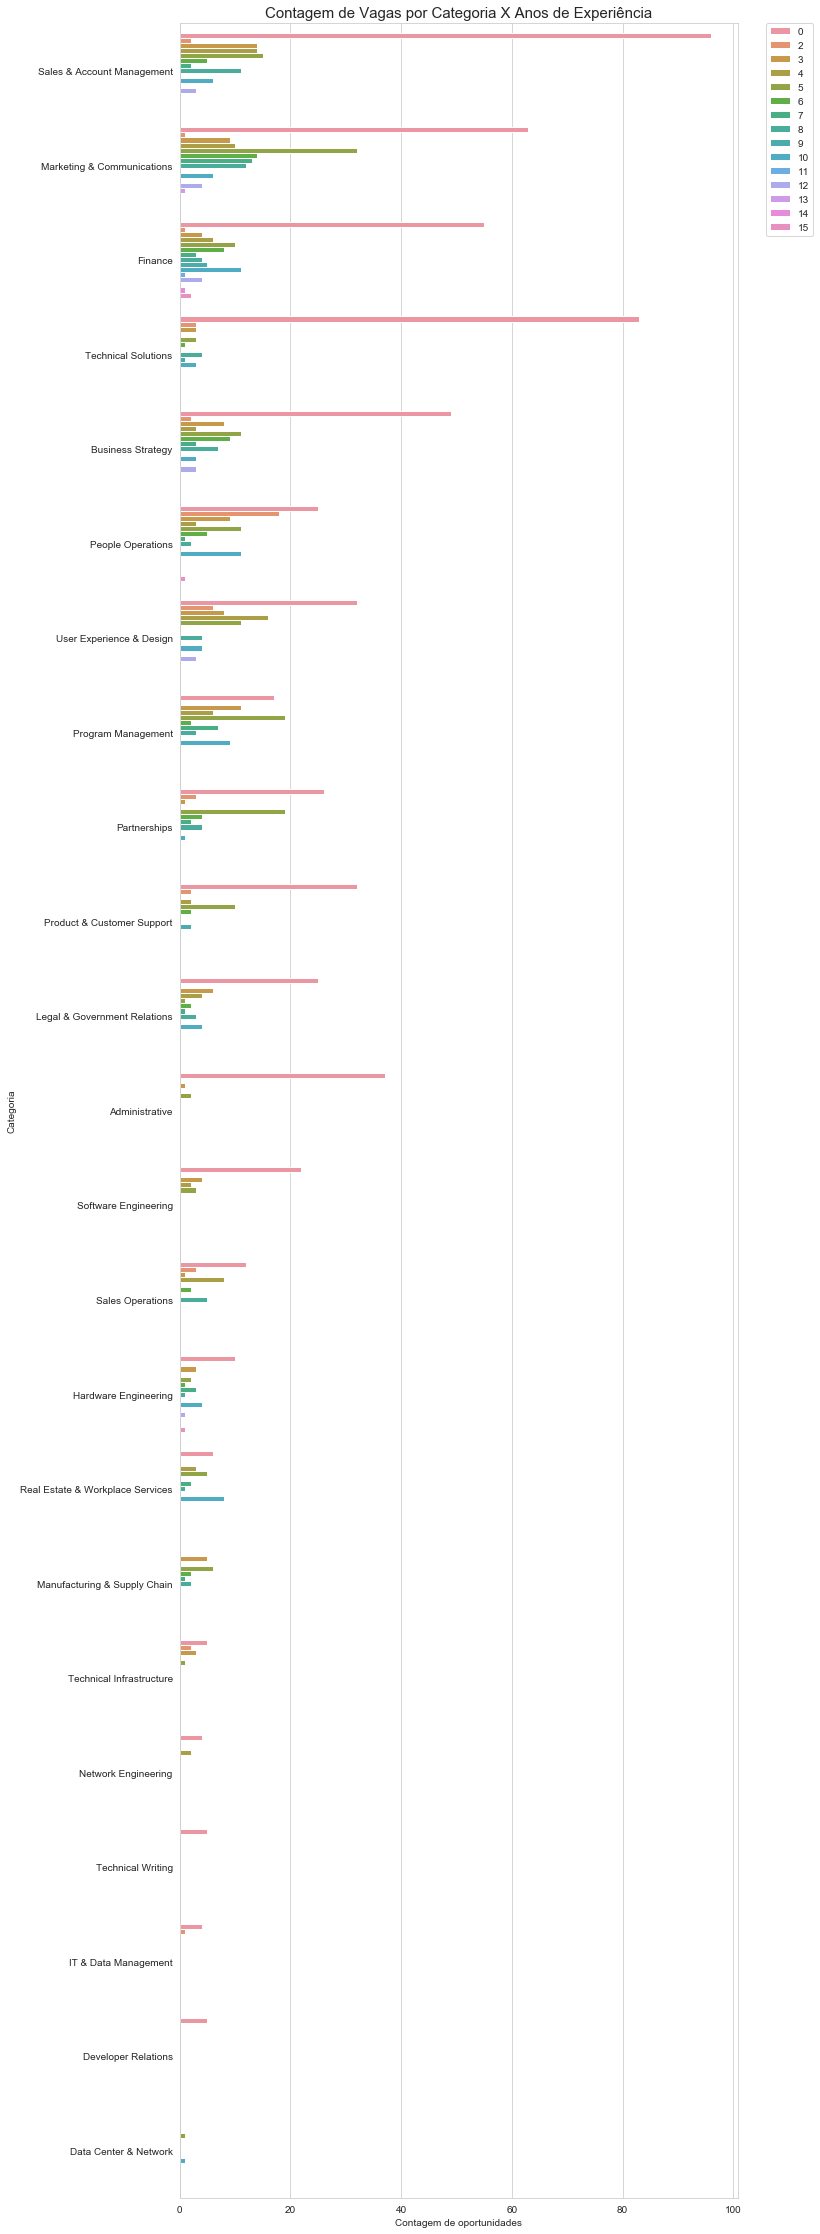

In [59]:
plt.figure(figsize=(10,40))
plt.title('Contagem de Vagas por Categoria X Anos de Experiência', fontsize=15)
sns.countplot(y='Category', data=df, order = df['Category'].value_counts().index, hue='Years of Experience')
plt.xlabel('Contagem de oportunidades')
plt.ylabel('Categoria')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Linguagens de programação

### Agora vamos analisar que linguagens de programação e tecnologias similares são mais requisitadas nas vagas:

Adotei como ponto de partida o seguinte site para facilitar minha busca por linguagens de programação:
https://www.ubuntupit.com/top-20-most-popular-programming-languages-to-learn-for-your-open-source-project/

In [60]:
df_prog = df[['Minimum Qualifications', 'Title', 'Category']].copy(deep=True)

In [61]:
popular_lang = ['JavaScript','Python', 'Java ', 'PHP', 'C', 'C#', 'C\+\+', 'TypeScript', 'Shell', 'Ruby', 
                'SQL', 'Swift', 'Go', 'R Programming Language', 'R', 'Perl', 'Kotlin', 'Rust',
               'Scheme', 'Elixir', 'Haskell', 'Scala', 'matlab', 'Stata', 'SAS', 'HTML', 'CSS', 
                'NodeJS', 'NET', 'Tableau',  'MapReduce', 'Hadoop', 'Spark', 'Flume', 'Hive', 'Impala', 'Spark', 'BigQuery']

#detalhe: esta lista será usada para encontrar padrões com regex. E C++ apresentará problemas com metacaracteres, motivo pelo 
# qual estou já inserindo a '\' para o '+' ser entendido apenas como um caractere e não como um metacaracter.

# Obs: desculpem-me por chamar HTML de linguagem... só achei que ela poderia pegar uma carona aqui. Da mesma forma, acrescentei
# Tableau, que é uma tecnologia de visualização, e não uma linguagem. E, generalizando o pensamento, resolvi acrescentar uma série
# de tecnologias relacionadas ao mundo da programação (tais como o Software BigQuery).

# Futuramente seria interessante ampliar esta abordagem para todas as hard skills e soft skills de todas as áreas.

popular_lang = [x.lower() for x in popular_lang]
popular_lang

['javascript',
 'python',
 'java ',
 'php',
 'c',
 'c#',
 'c\\+\\+',
 'typescript',
 'shell',
 'ruby',
 'sql',
 'swift',
 'go',
 'r programming language',
 'r',
 'perl',
 'kotlin',
 'rust',
 'scheme',
 'elixir',
 'haskell',
 'scala',
 'matlab',
 'stata',
 'sas',
 'html',
 'css',
 'nodejs',
 'net',
 'tableau',
 'mapreduce',
 'hadoop',
 'spark',
 'flume',
 'hive',
 'impala',
 'spark',
 'bigquery']

In [62]:
for lang in popular_lang:
    
    pattern = "[\s]\(?("+lang+")[.,;\/\)]?[\s]"

# Estou prevendo um espaço na anterior à ocorrência de cada palavra, bem como a possibilidade 
# de algum tipo de pontuação depois da palavra, seguido de novo espaço. Pensei justamente na necessidade de
# diferenciar 'C' e 'Java' de 'C#', 'C++' ou 'Javascript' (que tem 'Java' como parte da palavra).

# Finalmente, precisei acrescentar um espaço antecedendo 'C ' e 'R ' para não correr o risco de contar palavras terminadas em c ou r.

# Também considerei o caso da palavra estar englobada em parênteses. 

# Ainda podem existir ajustes a serem feitos, mas esta é uma aproximação boa para um primeiro exame.
    
    
    df_prog[lang] = df_prog['Minimum Qualifications'].apply(lambda x: 1 if re.search(pattern, str(x).lower()) else 0)

In [63]:
df_prog.sum()

javascript                68
python                    84
java                       0
php                        7
c                          9
c#                        15
c\+\+                     41
typescript                 0
shell                      5
ruby                      13
sql                       55
swift                      0
go                        21
r programming language     0
r                         32
perl                       6
kotlin                     3
rust                       0
scheme                     0
elixir                     0
haskell                    0
scala                      0
matlab                    17
stata                     11
sas                       18
html                      33
css                       19
nodejs                    10
net                       10
tableau                    6
mapreduce                  7
hadoop                     5
spark                      4
flume                      2
hive          

In [64]:
# Vou retirar a coluna referente a todas as linguagens de programação que não tiveram nehum representante:
for lang in popular_lang:
    if df_prog[lang].sum()==0:
        df_prog.drop(columns=[lang], inplace=True)

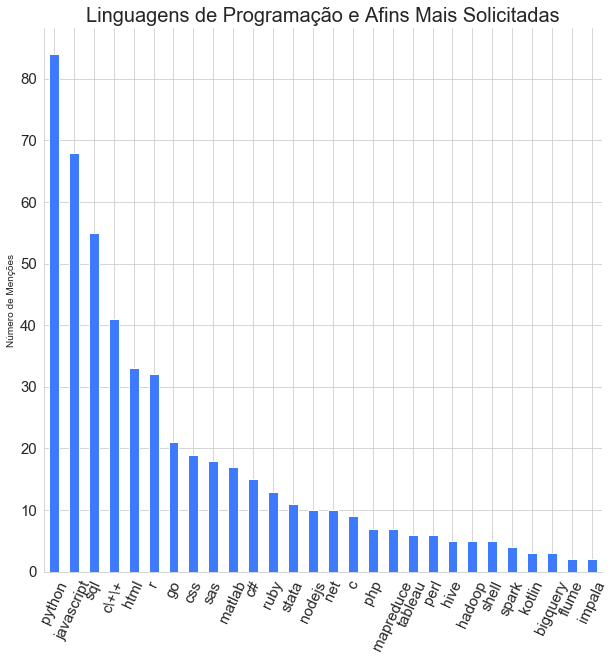

In [65]:
plt.figure(figsize=(10,10))
df_prog.sum().sort_values(ascending=False).plot('bar',  color='xkcd:lightish blue')
plt.title('Linguagens de Programação e Afins Mais Solicitadas', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Número de Menções')
plt.yticks(fontsize=15);
plt.xticks(fontsize=15, rotation=65);

In [66]:
df_prog.columns

Index(['Minimum Qualifications', 'Title', 'Category', 'javascript', 'python',
       'php', 'c', 'c#', 'c\+\+', 'shell', 'ruby', 'sql', 'go', 'r', 'perl',
       'kotlin', 'matlab', 'stata', 'sas', 'html', 'css', 'nodejs', 'net',
       'tableau', 'mapreduce', 'hadoop', 'spark', 'flume', 'hive', 'impala',
       'bigquery'],
      dtype='object')

In [67]:
df_prog[df_prog['c']==1]

Minimum Qualifications  \
17   BA/BS degree in Computer Science or related te...   
65   Master's degree in Computer Science or Electri...   
77   BA/BS degree or equivalent practical experienc...   
108  Master's degree in Computer Science or Electri...   
131  BS degree in Computer Science or related techn...   
147  3 years of experience with device hardware or ...   
166  BA/BS degree in Computer Science or related te...   
198  BS degree in Computer Science or related techn...   
281  BA/BS degree in computer science, related tech...   

                                                 Title  \
17   Software Engineering Manager, Cloud Storage, S...   
65             Software Engineer, Performance Modeling   
77                         Front End Software Engineer   
108             Software Engineer, Virtual Prototyping   
131    Software Engineer, Site Reliability Engineering   
147  Partner Engineer, Google Assistant, Google Tec...   
166                        Software Engineer (English)   
198     Systems Engineer, Site Reliability Engineering   
281                   Software Engineer, Accessibility   

                     Category  javascript  python  php  c  c#  c\+\+  shell  \
17       Software Engineering           0       1    0  1   0      1      1   
65       Software Engineering           0       0    0  1   0      1      0   
77       Software Engineering           0       0    0  1   0      1      0   
108      Software Engineering           0       0    0  1   0      0      0   
131  Technical Infrastructure           0       1    0  1   0      1      0   
147       Technical Solutions           0       0    0  1   0      1      0   
166      Software Engineering           1       1    0  1   1      1      0   
198  Technical Infrastructure           0       1    0  1   0      1      1   
281      Software Engineering           0       1    0  1   0      1      0   

     ...  nodejs  net  tableau  mapreduce  hadoop  spark  flume  hive  impala  \
17   ...       0    0        0          0       0      0      0     0       0   
65   ...       0    0        0          0       0      0      0     0       0   
77   ...       0    0        0          0       0      0      0     0       0   
108  ...       0    0        0          0       0      0      0     0       0   
131  ...       0    0        0          0       0      0      0     0       0   
147  ...       0    0        0          0       0      0      0     0       0   
166  ...       0    0        0          0       0      0      0     0       0   
198  ...       0    0        0          0       0      0      0     0       0   
281  ...       0    0        0          0       0      0      0     0       0   

     bigquery  
17          0  
65          0  
77          0  
108         0  
131         0  
147         0  
166         0  
198         0  
281         0  

[9 rows x 31 columns]

In [68]:
df_prog.iloc[108]['Minimum Qualifications'] #Apenas verificando a exigência de C.

"Master's degree in Computer Science or Electrical Engineering or equivalent practical experience.\n3 years of working experience\nExperience with algorithms and data structures.\nProgramming experience in C or C++."

In [69]:

#Para vermos um pouco de como as competências em cada linguagem são requeridas em cada campo de atuação.

category_lang = pd.pivot_table(data=df_prog, index=['Category'], aggfunc='sum').T
category_lang

Category    Administrative  Business Strategy  Data Center & Network  \
bigquery                 0                  0                      0   
c                        0                  0                      0   
c#                       0                  0                      0   
c\+\+                    0                  0                      0   
css                      0                  0                      0   
flume                    0                  0                      0   
go                       1                  0                      0   
hadoop                   0                  0                      0   
hive                     0                  0                      0   
html                     0                  0                      0   
impala                   0                  0                      0   
javascript               0                  0                      0   
kotlin                   0                  0                      0   
mapreduce                0                  0                      0   
matlab                   0                 11                      0   
net                      0                  0                      0   
nodejs                   0                  0                      0   
perl                     0                  0                      0   
php                      0                  0                      0   
python                   3                  2                      0   
r                        0                 11                      0   
ruby                     0                  0                      0   
sas                      0                  9                      0   
shell                    0                  0                      0   
spark                    0                  0                      0   
sql                      2                 13                      0   
stata                    0                  9                      0   
tableau                  0                  0                      0   

Category    Developer Relations  Finance  Hardware Engineering  \
bigquery                      0        1                     0   
c                             0        0                     0   
c#                            1        0                     0   
c\+\+                         0        0                     0   
css                           0        0                     0   
flume                         0        0                     0   
go                            1        0                     0   
hadoop                        0        1                     0   
hive                          0        1                     0   
html                          0        0                     0   
impala                        0        0                     0   
javascript                    2        0                     0   
kotlin                        3        0                     0   
mapreduce                     0        0                     0   
matlab                        0        1                     0   
net                           0        0                     0   
nodejs                        0        0                     0   
perl                          0        0                     1   
php                           1        0                     0   
python                        2        1                     1   
r                             0        1                     0   
ruby                          1        0                     0   
sas                           0        0                     0   
shell                         0        0                     1   
spark                         0        0                     0   
sql                           0        3                     0   
stata                         0        0                     0   
tableau                       0        0                     1 

In [70]:
df_prog[df_prog['python']==1]

Minimum Qualifications  \
2     Bachelor’s degree in Business, Economics, Stat...   
9     BA/BS degree in Computer Science, related Soft...   
13    BA/BS degree in a technical or quantitative/bu...   
14    BA/BS degree in a technical or engineering fie...   
17    BA/BS degree in Computer Science or related te...   
20    PhD in Statistics or Econometrics or a related...   
21    BA/BS degree in Computer Science or other rela...   
23    BA/BS degree in a technical or quantitative/bu...   
31    BA/BS degree in Computer Science or a related ...   
41    BA/BS degree in Computer Science, related Soft...   
45    BA/BS degree in a technical or engineering fie...   
47    BA/BS degree or equivalent practical experienc...   
48    BA/BS degree in Computer Science, related Soft...   
53    BA/BS degree in Computer Science or related so...   
55    BS degree in a technical or engineering field ...   
63    Bachelor's degree in Computer Science, Mathema...   
69    BA/BS degree in Computer Science or a related ...   
75    BA/BS degree or equivalent practical experienc...   
76    BA/BS degree in Computer Science or a related ...   
78    BA/BS degree in Computer Science, Mathematics ...   
84    BA/BS in Computer Science or Robotics, or equi...   
88    BA/BS degree or equivalent practical experienc...   
104   BA/BS degree in Computer Science or a related ...   
111   Experience with management, security and optim...   
115   BA/BS degree in a technical or engineering fie...   
122   BA/BS degree in Computer Science or a related ...   
126   BA/BS degree or equivalent practical experienc...   
127   BS degree in Computer Science or related techn...   
131   BS degree in Computer Science or related techn...   
145   BA/BS degree or equivalent practical experienc...   
...                                                 ...   
268   BS degree in Computer Science or related techn...   
276   BA/BS degree in Computer Science, Mathematics ...   
278   Bachelor's degree in Computer Science, Mathema...   
279   BA/BS degree in Computer Science, related Soft...   
281   BA/BS degree in computer science, related tech...   
287   BA/BS degree in a technical or engineering fie...   
290   BA/BS degree in Computer Science or a related ...   
291   BA/BS degree in a technical or engineering fie...   
308   BA/BS degree in a technical or quantitative/bu...   
316   PhD in Statistics or Econometrics or a related...   
323   BA/BS degree in a technical or quantitative/bu...   
373   BA/BS degree in Statistics, Applied Mathematic...   
376   BA/BS degree in Statistics, Applied Mathematic...   
438   BS degree in Computer Science, Applied Mathema...   
508   BS degree in a technical or engineering field ...   
578   Bachelor's degree in Computer Science, Statist...   
650   BA/BS degree in Statistics, Applied Mathematic...   
765   BA/BS degree in Engineering, Computer Science,...   
795   BA/BS degree in Computer Science, Human-Comput...   
842   BA/BS degree in Computer Science, Human-Comput...   
847   Master’s degree/PhD in computational social sc...   
860   BA/BS degree in Computer Science, Human-Comput...   
909   MS degree in a quantitative discipline (e.g., ...   
933   MS degree in a quantitative discipline (e.g., ...   
985   BA/BS degree in Computer Science, related tech...   
1128  BA/BS degree in Economics, Statistics, Finance...   
1177  Bachelor's degree in Engineering, Computer Sci...   
1186  BA/BS degree or equivalent practical experienc...   
1199  BA/BS degree in Computer Science or a related ...   
1203  BA/BS degree in Computer Science or a related ...   

                                                  Title  \
2     Data Analyst, Product and Tools Operations, Go...   
9     Solutions Architect, Healthcare and Life Scien...   
13                    Survey Lead, Google Cloud Support   
14    Solution Architect, Google Cloud Platform (Api...   
17    Software Engineering Manager, Cloud Storage, S...   
20                  

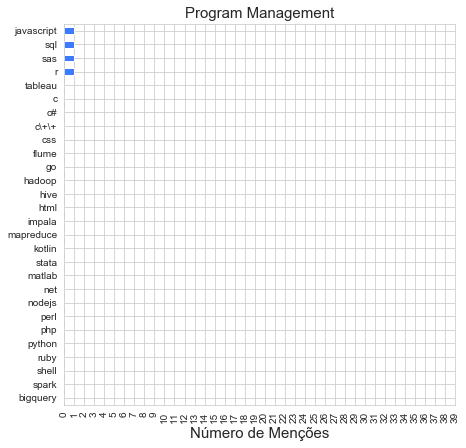

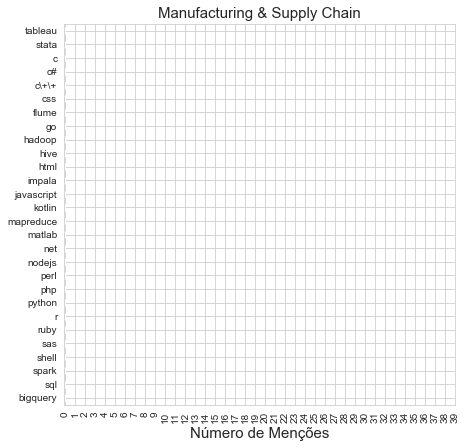

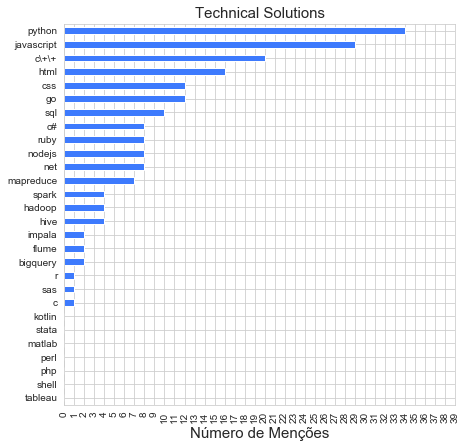

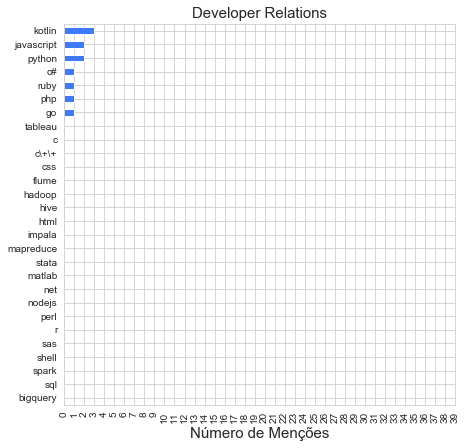

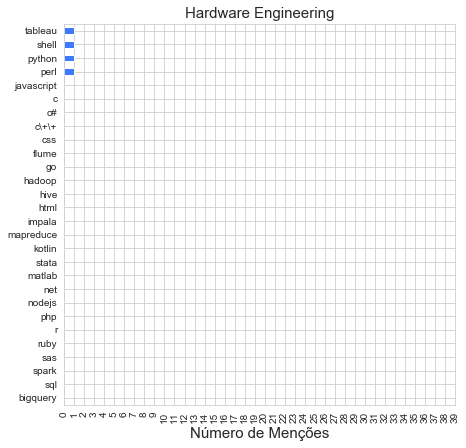

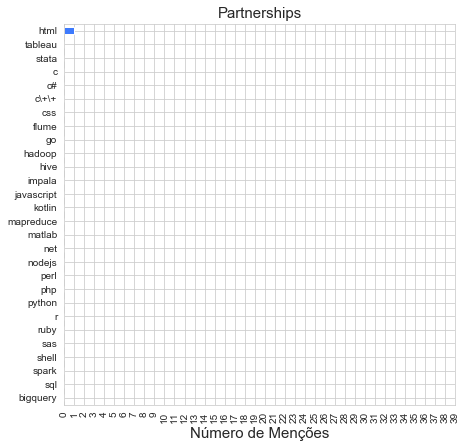

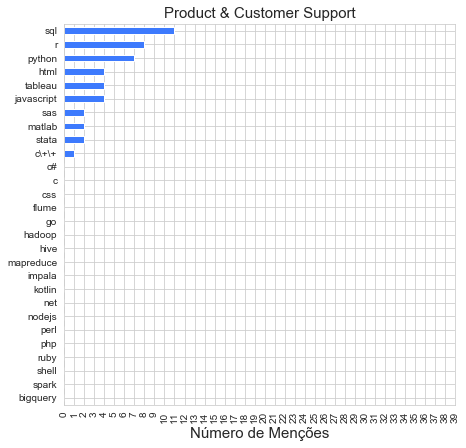

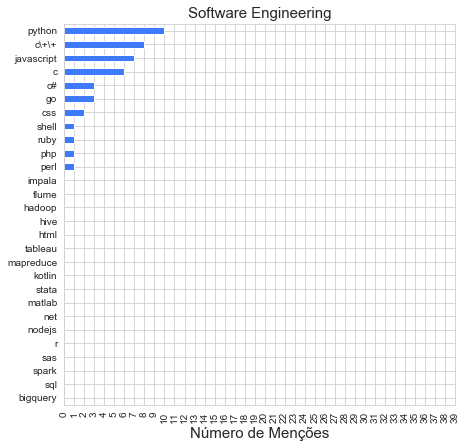

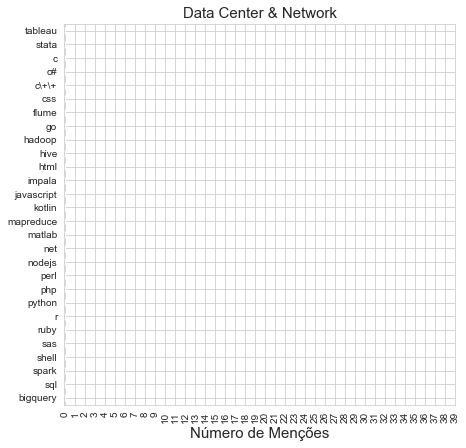

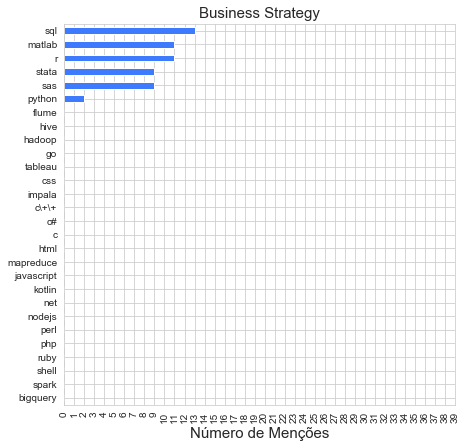

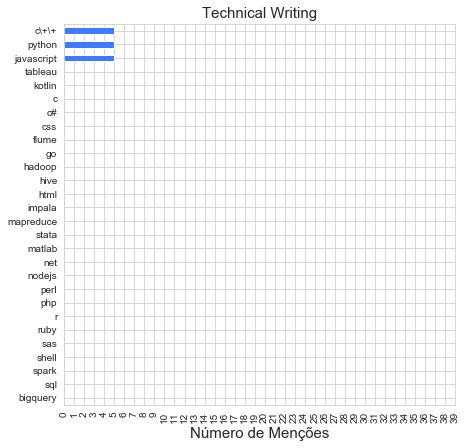

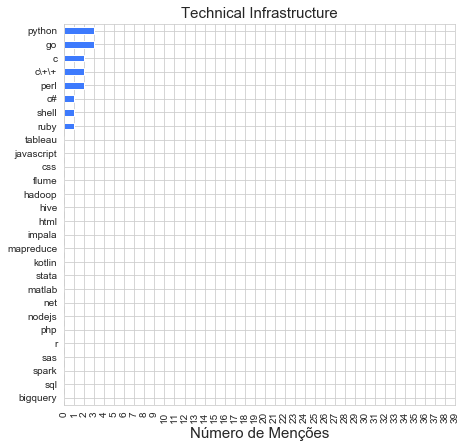

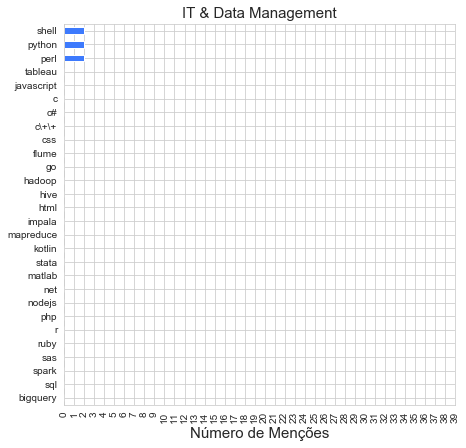

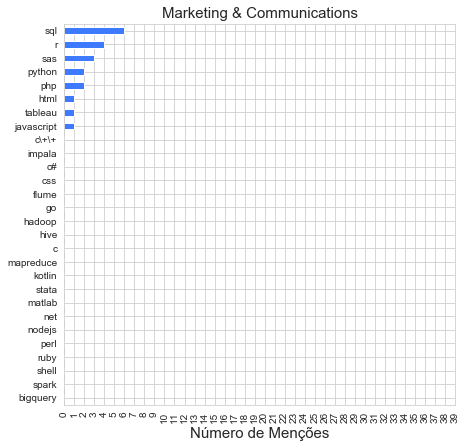

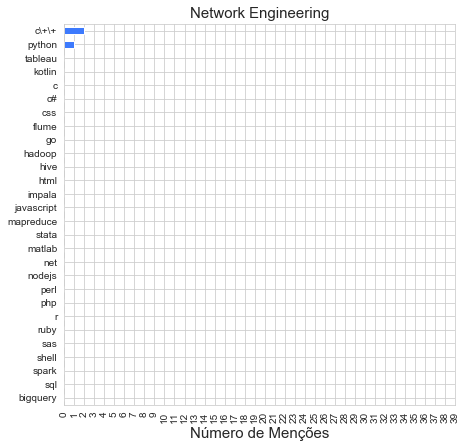

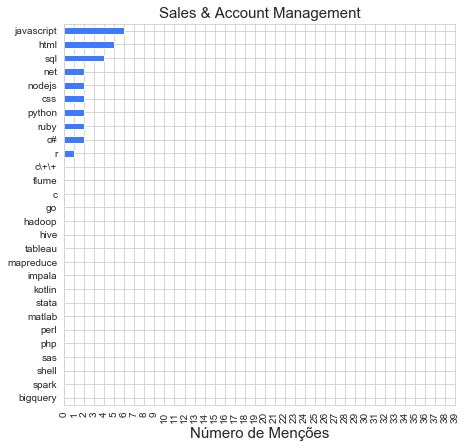

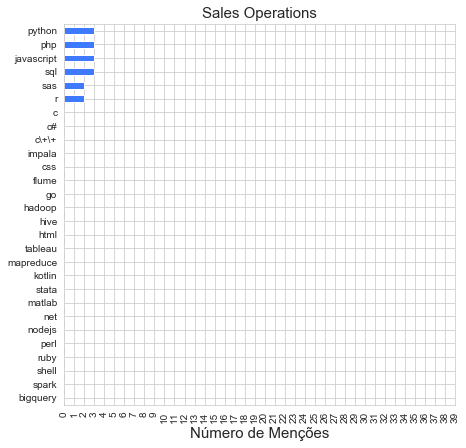

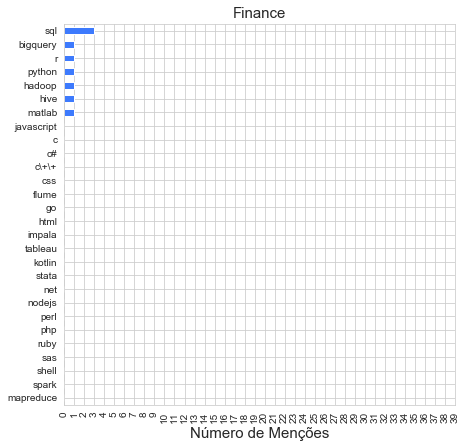

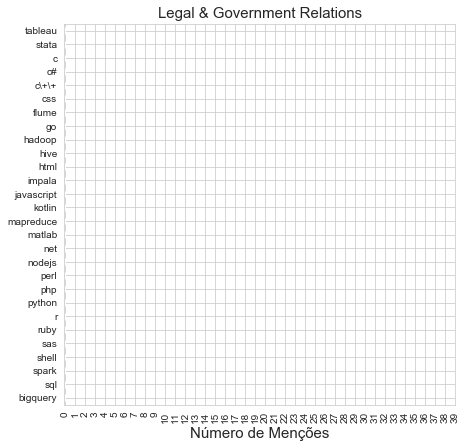

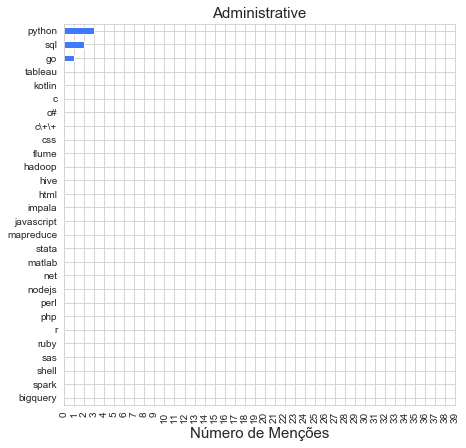

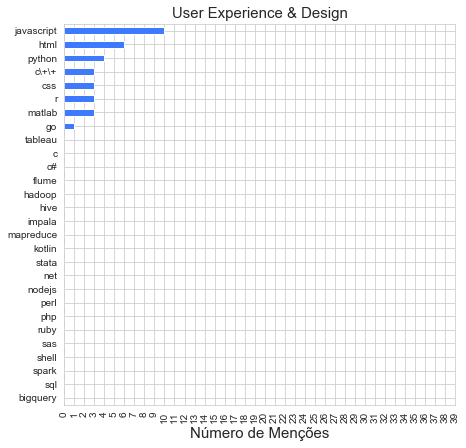

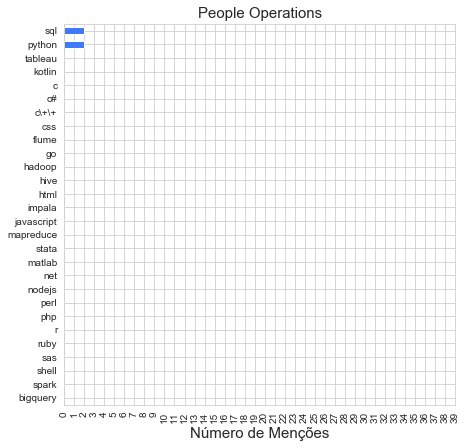

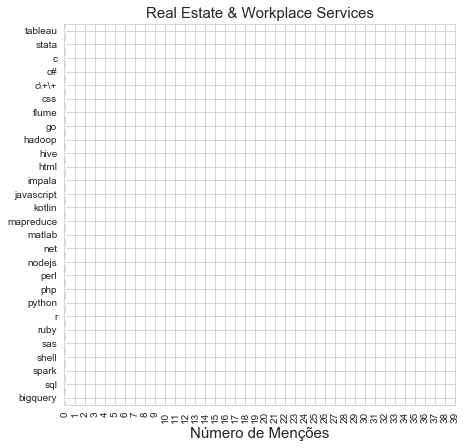

In [71]:
# Neste quero investigar a distribuição de linguagens de programação por setor. 
# Manterei a mesma escala para todos os gráficos para ter visão de escala.

for cat in list(df_prog.Category.unique()):
    plt.figure(figsize=(7,7))
    plt.title(cat, fontsize=15)
    category_lang[cat].sort_values().plot(kind='barh', color='xkcd:lightish blue')
    plt.xticks([n for n in range(40)])
    plt.xticks(rotation=90)
    plt.xlabel('Número de Menções', fontsize=15)
    plt.show()

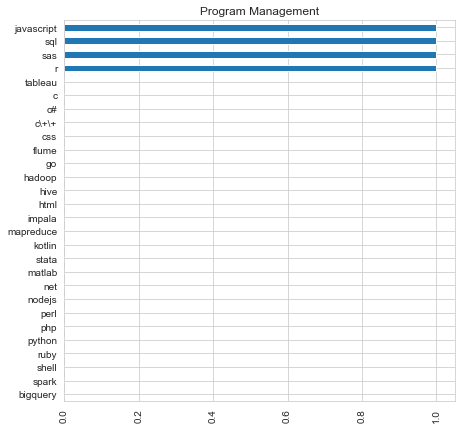

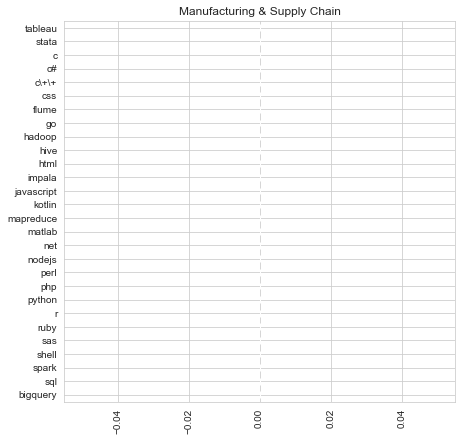

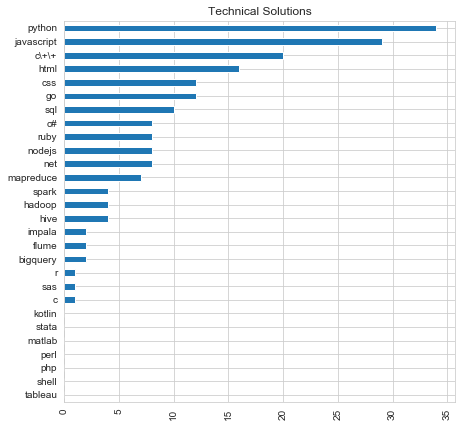

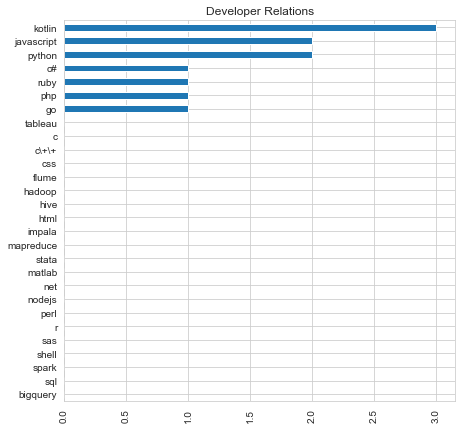

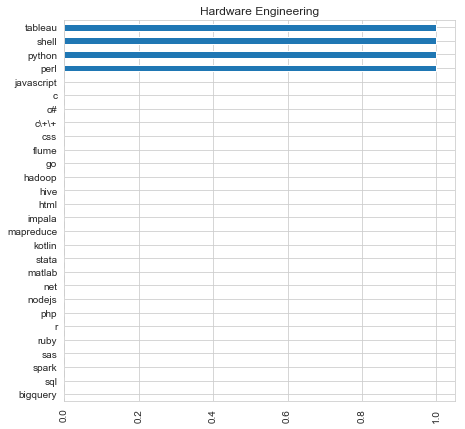

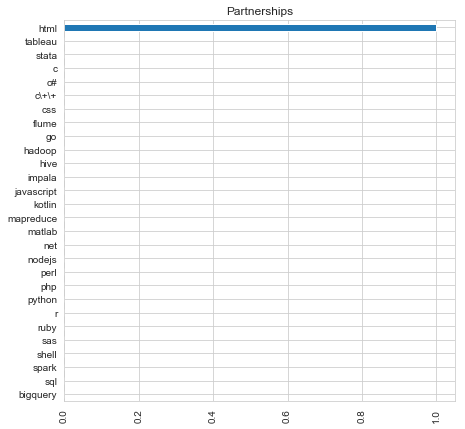

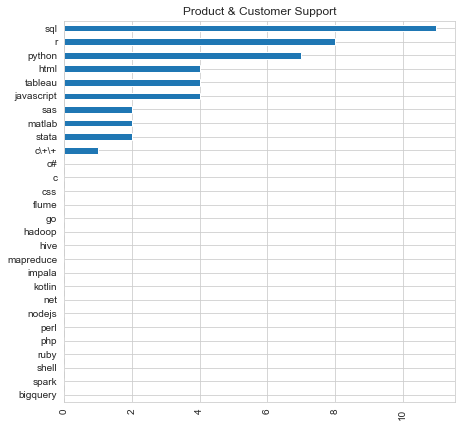

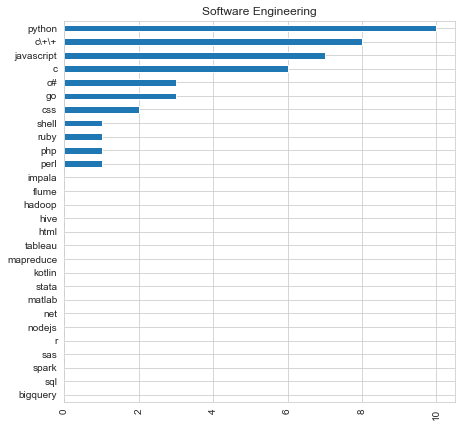

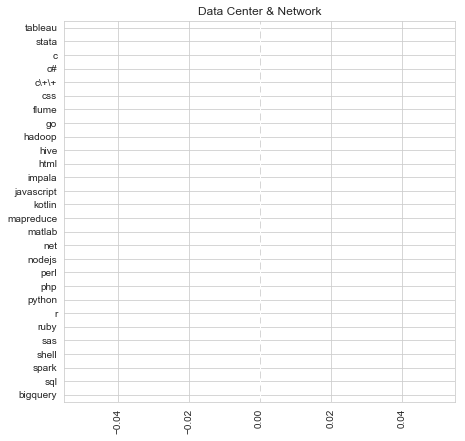

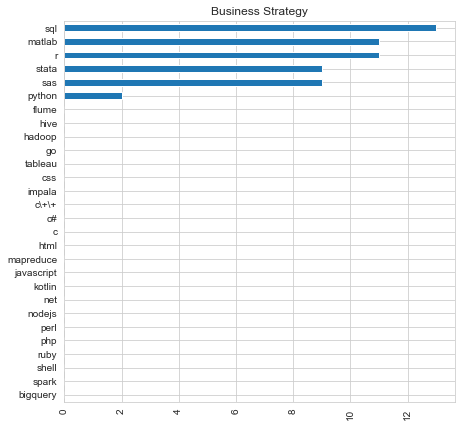

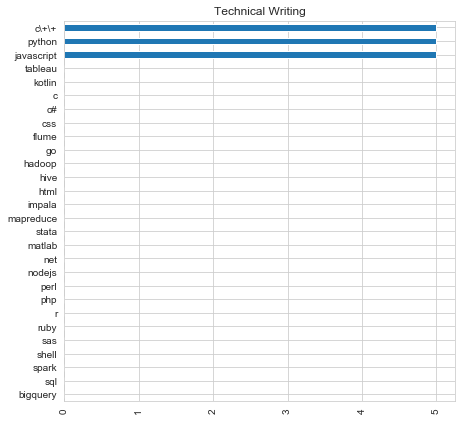

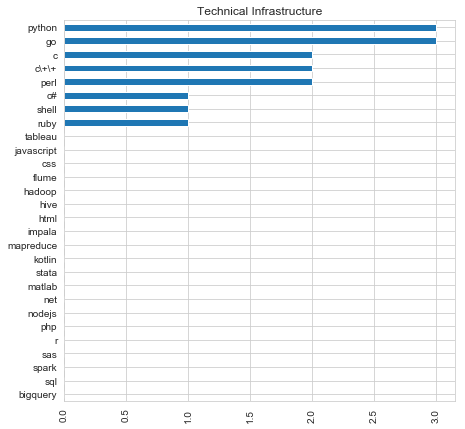

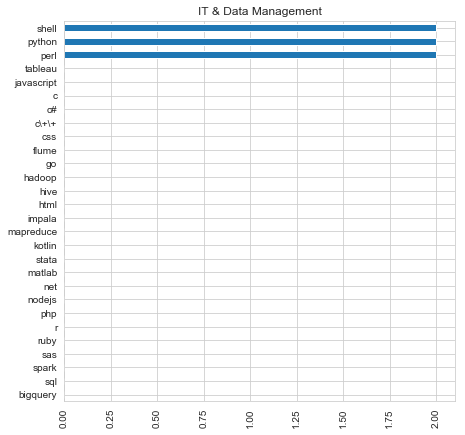

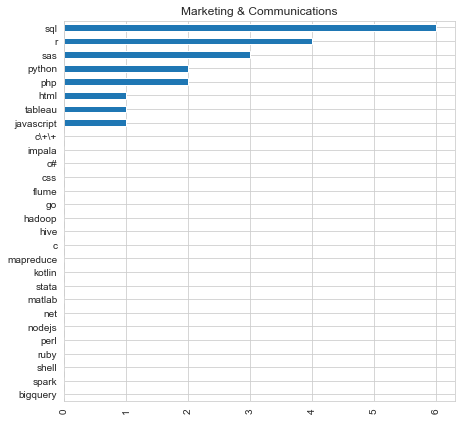

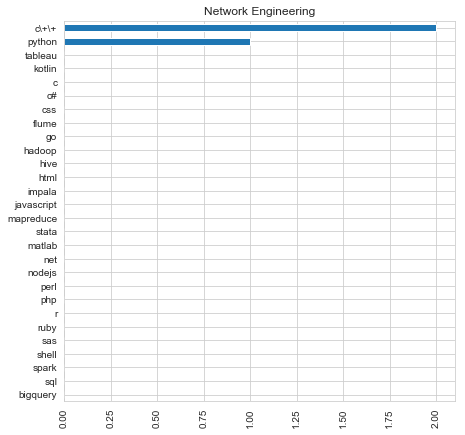

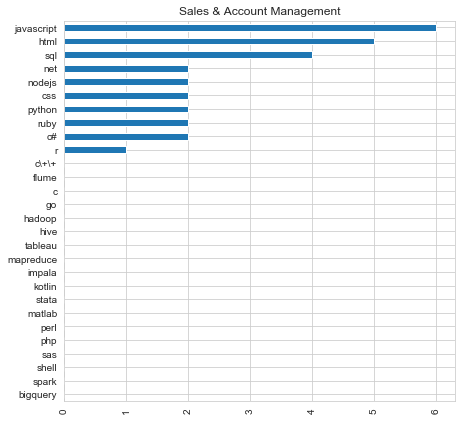

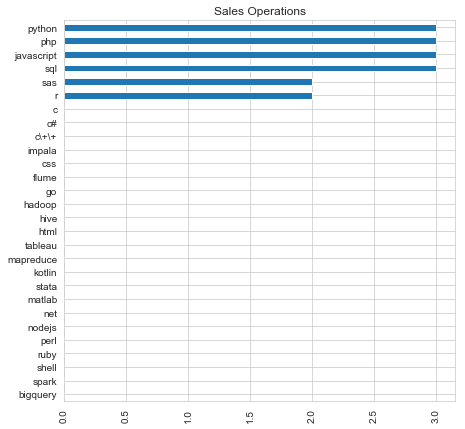

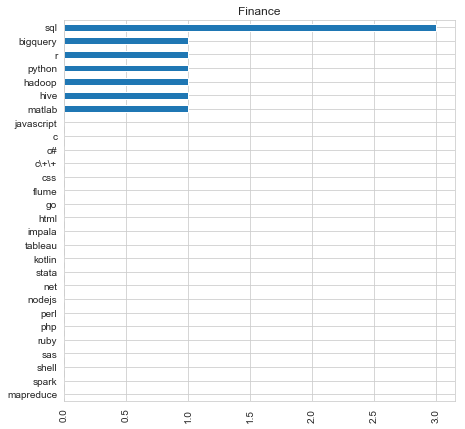

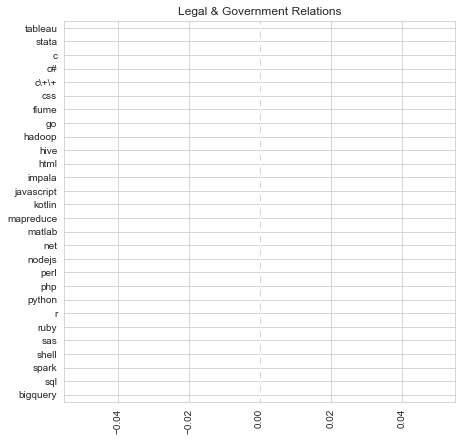

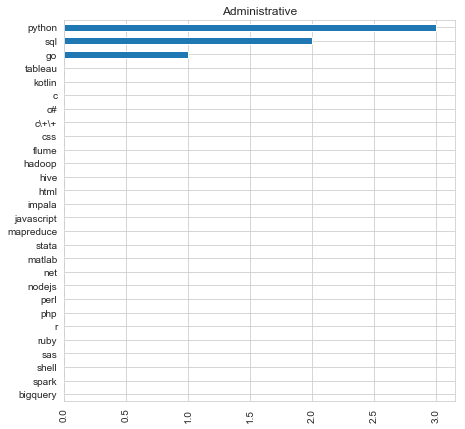

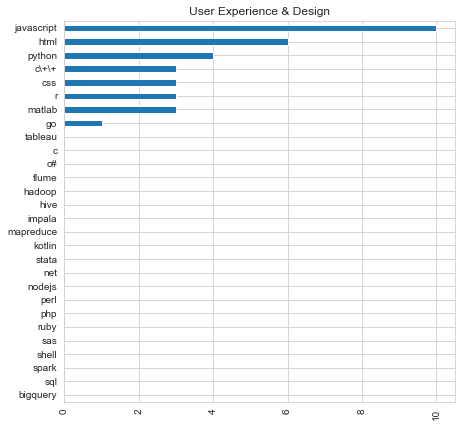

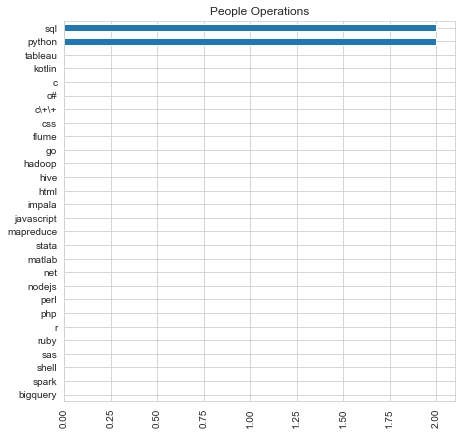

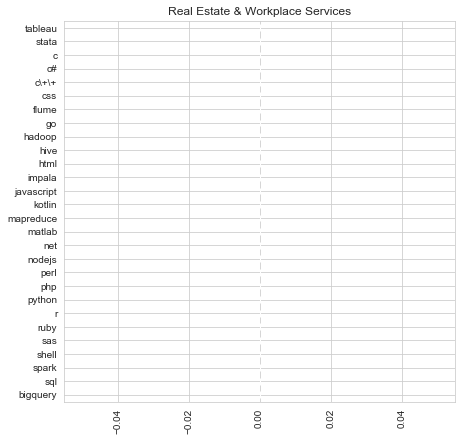

In [72]:
# neste darei preferência para ajustar à melhor escala para cada caso:

# Obs: sei que não é bonito um gráfico que não mostra nada, como no caso de 'Real State & Workplace Services', mas
# vou mantê-lo apenas como um lembrete de que a categoria existe, mas não exige linguagens de programação.
for cat in list(df_prog.Category.unique()):
    plt.figure(figsize=(7,7))
    plt.title(cat)
    category_lang[cat].sort_values().plot(kind='barh')
    plt.xticks(rotation=90)
    plt.show()

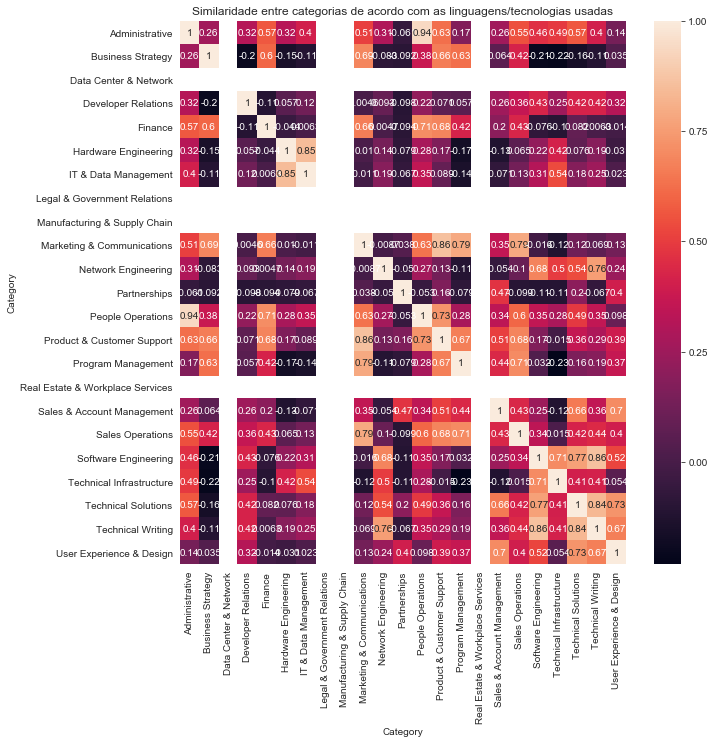

In [73]:
plt.figure(figsize=(10,10))
plt.title('Similaridade entre categorias de acordo com as linguagens/tecnologias usadas')
sns.heatmap(category_lang.corr(), annot=True);

In [74]:
# A primeira tentativa de abordar este problema de forma generalista será a partir de um bag_of_words, 
# para verificar a frequência com que cada palavra aparece.


In [104]:
#from scipy.spatial.distance import pdist, squareform
similar = pd.DataFrame(1/(1+squareform(pdist(category_lang.T, 'euclidean'))), 
                       index=category_lang.columns, 
                       columns=category_lang.columns)


similar

# Aqui estamos calculando a similaridade entre as categorias considerando distância euclidiana temdo como base 
# as skills relacionadas a programação. No futuro será interessante enriquecer o dataset com outras soft e hard skills
# relacionadas a todas as áreas. E estou fazendo isso com relação a Categorias, mas poderia ter feiro com relação ao 
#título das vagas.

Category                          Administrative  Business Strategy  \
Category                                                              
Administrative                          1.000000           0.041742   
Business Strategy                       0.041742           1.000000   
Data Center & Network                   0.210897           0.039967   
Developer Relations                     0.179129           0.039541   
Finance                                 0.231662           0.044273   
Hardware Engineering                    0.224009           0.039967   
IT & Data Management                    0.210897           0.039834   
Legal & Government Relations            0.210897           0.039967   
Manufacturing & Supply Chain            0.210897           0.039967   
Marketing & Communications              0.123899           0.051229   
Network Engineering                     0.217129           0.039934   
Partnerships                            0.205213           0.039934   
People Operations                       0.414214           0.041818   
Product & Customer Support              0.062762           0.057772   
Program Management                      0.210897           0.042205   
Real Estate & Workplace Services        0.210897           0.039967   
Sales & Account Management              0.096331           0.041076   
Sales Operations                        0.158945           0.044971   
Software Engineering                    0.062762           0.033903   
Technical Infrastructure                0.172538           0.039286   
Technical Solutions                     0.017492           0.016507   
Technical Writing                       0.115192           0.038256   
User Experience & Design                0.069910           0.038670   

Category                          Data Center & Network  Developer Relations  \
Category                                                                       
Administrative                                 0.210897             0.179129   
Business Strategy                              0.039967             0.039541   
Data Center & Network                          1.000000             0.179129   
Developer Relations                            0.179129             1.000000   
Finance                                        0.205213             0.150221   
Hardware Engineering                           0.333333             0.179129   
IT & Data Management                           0.224009             0.166667   
Legal & Government Relations                   1.000000             0.179129   
Manufacturing & Supply Chain                   1.000000             0.179129   
Marketing & Communications                     0.105426             0.102302   
Network Engineering                            0.309017             0.175734   
Partnerships                                   0.500000             0.175734   
People Operations                              0.261204             0.179129   
Product & Customer Support                     0.055019             0.057168   
Program Management                             0.333333             0.179129   
Real Estate & Workplace Services               1.000000             0.179129   
Sales & Account Management                     0.090094             0.098908   
Sales Operations                               0.131006             0.144591   
Software Engineering                           0.056873             0.064266   
Technical Infrastructure                       0.148268             0.150221   
Technical Solutions                            0.016839             0.017582   
Technical Writing                              0.103517             0.117878   
User Experience & Design                       0.067807             0.075025   

Category                           Finance  Hardware Engineering  \
Category                                                           
Administrative                    0.231662              0.224009   
Business Strategy  

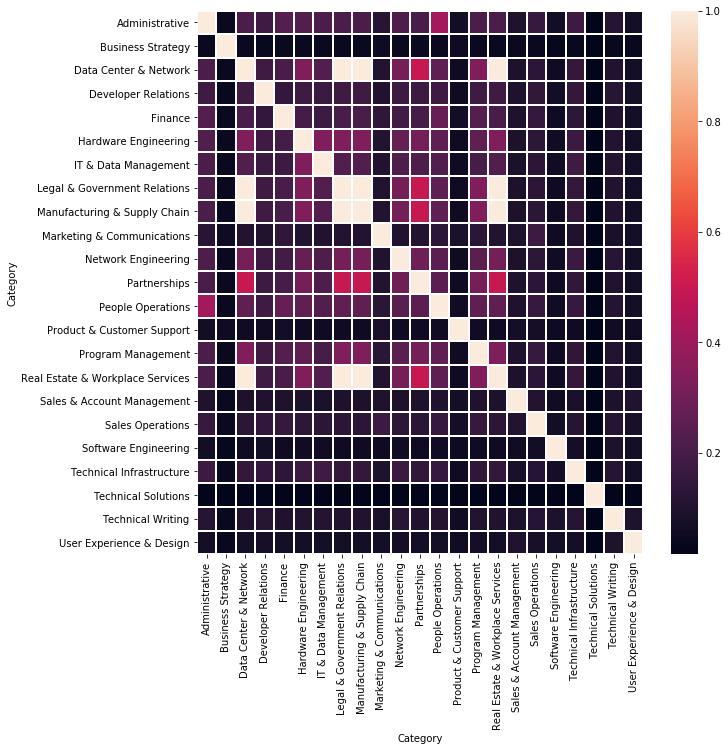

In [110]:
plt.figure(figsize=(10,10))
sns.heatmap(data=similar, linewidths=1);

In [75]:
df['MQ_degree'].value_counts()

ba/bs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [76]:
df.head()

Company                                              Title  \
0  Google                       Google Cloud Program Manager   
1  Google  Supplier Development Engineer (SDE), Cable/Con...   
2  Google  Data Analyst, Product and Tools Operations, Go...   
3  Google            Developer Advocate, Partner Engineering   
4  Google     Program Manager, Audio Visual (AV) Deployments   

                       Category                          Location  \
0            Program Management                         Singapore   
1  Manufacturing & Supply Chain                   Shanghai, China   
2           Technical Solutions       New York, NY, United States   
3           Developer Relations  Mountain View, CA, United States   
4            Program Management      Sunnyvale, CA, United States   

                                    Responsibilities  \
0  Shape, shepherd, ship, and show technical prog...   
1  Drive cross-functional activities in the suppl...   
2  Collect and analyze data to draw insight and i...   
3  Work one-on-one with the top Android, iOS, and...   
4  Plan requirements with internal customers.\nPr...   

                              Minimum Qualifications  \
0  BA/BS degree or equivalent practical experienc...   
1  BS degree in an Engineering discipline or equi...   
2  Bachelor’s degree in Business, Economics, Stat...   
3  BA/BS degree in Computer Science or equivalent...   
4  BA/BS degree or equivalent practical experienc...   

                            Preferred Qualifications  Countries MQ_degree  \
0  Experience in the business technology market a...  Singapore     ba/bs   
1  BSEE, BSME or BSIE degree.\nExperience of usin...      China        bs   
2  Experience partnering or consulting cross-func...        USA  bachelor   
3  Experience as a software developer, architect,...        USA     ba/bs   
4  CTS Certification.\nExperience in the construc...        USA     ba/bs   

   Years of Experience  
0                    3  
1                    7  
2                    2  
3                    0  
4                    4

In [77]:
# Field for minimum qualification

In [78]:


def find_field(string):
    finded = re.findall(r'in (.*?)\.', string) #encontrando descrições após palavra in e antes do próximo ponto. 
    try: 
        finded = finded[0]
        return finded 
    except:
        return finded

df['MQ_field'] = df['Minimum Qualifications'].dropna().apply(lambda x: find_field(x))

In [79]:
df['MQ_field'] = df['MQ_field'].astype(str)

In [80]:
df['MQ_field'].unique()

array(['program and/or project management in cloud computing, enterprise software and/or marketing technologies',
       'an Engineering discipline or equivalent practical experience',
       'Business, Economics, Statistics, Operations Research or related analytical field, or equivalent practical experience',
       'Computer Science or equivalent practical experience',
       'Audio/Visual and Video Conferencing design, system integration and resolution',
       'English and Czech and/or Slovak fluently and idiomatically',
       'Engineering or equivalent practical experience',
       'Partner Management and/or Business Development',
       'Engineering, Supply Chain or equivalent practical experience',
       'Computer Science, related Software Engineering field or equivalent practical experience',
       'Computer Science, Engineering, Economics, Business or a related degree, or equivalent practical experience',
       'program management, partner development and/or channel sales 

In [81]:
corpus = []

corpus = list(df['Minimum Qualifications'].dropna().values)

def removeStuff(string):
    import re # pacote para executar regex
    pattern = [
    r"[.%!+;={}():/\[\]\@\?\"]",   #remove pontuação
    r"\d*",          #remove números (vamos eliminá-los em uma primeira análise)
    r"\b[a-z]\b",    #remove caracteres únicos
    ]  
    for x in pattern:
        string = re.sub(x, '', string)
    return string

corpus = [removeStuff(string) for string in corpus]


In [82]:

list_stop_words = list(stop_words.ENGLISH_STOP_WORDS)

vectorizer = CountVectorizer()
freq = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['ab', 'abap', 'ability', 'able', 'abstracting', 'abuse', 'acceleration', 'access', 'accommodate', 'account', 'accountant', 'accounting', 'accounts', 'accreditation', 'achieve', 'acquisition', 'acquisitions', 'across', 'act', 'acting', 'activation', 'active', 'activities', 'activity', 'ad', 'addition', 'additional', 'address', 'adds', 'ade', 'adhesives', 'administration', 'administrative', 'administrator', 'admitted', 'adobe', 'ads', 'adtech', 'advanced', 'advertisers', 'advertising', 'advising', 'advisor', 'advocate', 'adwords', 'affairs', 'affect', 'after', 'against', 'age', 'agencies', 'agency', 'ages', 'agile', 'agreement', 'agreements', 'air', 'aires', 'aitiaca', 'ajax', 'algorithm', 'algorithms', 'aligned', 'all', 'allegro', 'allow', 'ambiguous', 'america', 'americas', 'aml', 'amp', 'an', 'analog', 'analogrf', 'analyses', 'analysis', 'analysisresearch', 'analyst', 'analytical', 'analytically', 'analyticaltechnicalconsulting', 'analytics', 'analyze', 'analyzer', 'analyzers', 'anal

In [83]:
print(freq.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [84]:
FreqPalavras = pd.DataFrame(freq.toarray(), columns=vectorizer.get_feature_names())
FreqPalavras

ab  abap  ability  able  abstracting  abuse  acceleration  access  \
0      0     0        0     0            0      0             0       0   
1      0     0        1     0            0      0             0       0   
2      0     0        0     0            0      0             0       0   
3      0     0        0     0            0      0             0       0   
4      0     0        0     0            0      0             0       0   
5      0     0        1     0            0      0             0       0   
6      0     0        0     0            0      0             0       0   
7      0     0        0     0            0      0             0       0   
8      0     0        0     0            0      0             0       0   
9      0     0        0     0            0      0             0       0   
10     0     0        0     0            0      0             0       0   
11     0     0        0     0            0      0             0       0   
12     0     0        1     0            0      0             0       0   
13     0     0        0     0            0      0             0       0   
14     0     0        1     0            0      0             0       0   
15     0     0        1     0            0      0             0       0   
16     0     0        0     0            0      0             0       0   
17     0     0        0     0            0      0             0       0   
18     0     0        0     0            0      0             0       0   
19     0     0        0     0            0      0             0       0   
20     0     0        0     0            0      0             0       0   
21     0     0        1     0            0      0             0       0   
22     0     0        0     0            0      0             0       0   
23     0     0        0     0            0      0             0       0   
24     0     0        2     0            0      0             0       0   
25     0     0        1     0            0      0             0       0   
26     0     0        0     0            0      0             0       0   
27     0     0        1     0            0      0             0       0   
28     0     0        0     0            0      0             0       0   
29     0     0        0     0            0      0             0       0   
...   ..   ...      ...   ...          ...    ...           ...     ...   
1206   0     0        0     0            0      0             0       0   
1207   0     0        0     0            0      0             0       0   
1208   0     0        1     0            0      0             0       0   
1209   0     0        1     0            0      0             0       0   
1210   0     0        1     0            0      0             0       0   
1211   0     0        0     0            0      0             0       0   
1212   0     0        0     0            0      0             0       0   
1213   0     0        0     0            0      0             0       0   
1214   0     0        0     0            0      0             0       0   
1215   0     0        0     0            0      0             0       0   
1216   0     0        1     0            0      0             0       0   
1217   0     0        1     0            0      0             0       0   
1218   0     0        0     0            0      0             0       0   
1219   0     0        0     0            0      0             0       0   
1220   0     0        0     0            0      0             0       0   
1221   0     0        1     0            0      0             0       0   
1222   0     0        0     0            0      0             0       0   
1223   0     0        0     0            0      0             0       0   
1224   0     0        1     0            0      0             0       0   
1225   0     0        0     0            0      0             0       0   
1226   0     0        0     0            0      0             0       0   
1227   0     0        0     0  

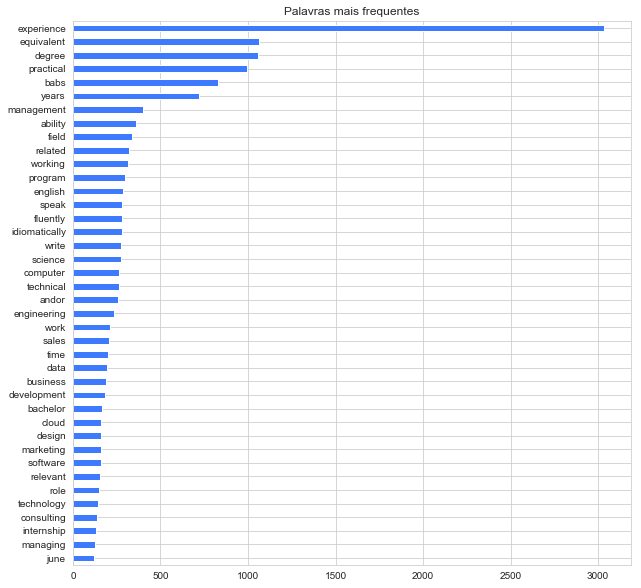

In [85]:
retirar = [word for word in list_stop_words if word in list(vectorizer.get_feature_names())]

plt.figure(figsize=(10,10))
plt.title('Palavras mais frequentes')
FreqPalavras.drop(columns=retirar).sum().sort_values(ascending=False)[0:40].sort_values(ascending=True).plot(kind='barh', color='xkcd:lightish blue');

In [86]:
#detalhe: o babs refere-se a 'ba/bs'

In [87]:
# Vou repetir o processo com a coluna recém criada: MQ_field

['account', 'accounting', 'acquisition', 'across', 'act', 'activity', 'ad', 'administration', 'administrative', 'administrator', 'admitted', 'adtech', 'advanced', 'advertising', 'advisor', 'after', 'agencies', 'agency', 'agile', 'agreement', 'allegro', 'ambiguous', 'america', 'aml', 'an', 'analyses', 'analysis', 'analyst', 'analytical', 'analyticaltechnicalconsulting', 'analytics', 'analyze', 'anaplan', 'and', 'andor', 'another', 'anthropology', 'anti', 'any', 'applications', 'applied', 'applying', 'apps', 'arabic', 'architecting', 'architecture', 'architectures', 'are', 'area', 'areas', 'argentina', 'arts', 'as', 'asian', 'assemblytest', 'at', 'audiovisual', 'audit', 'authorized', 'automation', 'award', 'babs', 'bachelor', 'backend', 'bank', 'banking', 'bankingventure', 'based', 'bb', 'bc', 'before', 'between', 'both', 'brand', 'brazil', 'brazilian', 'bsa', 'build', 'building', 'business', 'businesscommerce', 'buyer', 'buying', 'cad', 'campaign', 'cantonese', 'capacities', 'capacity',

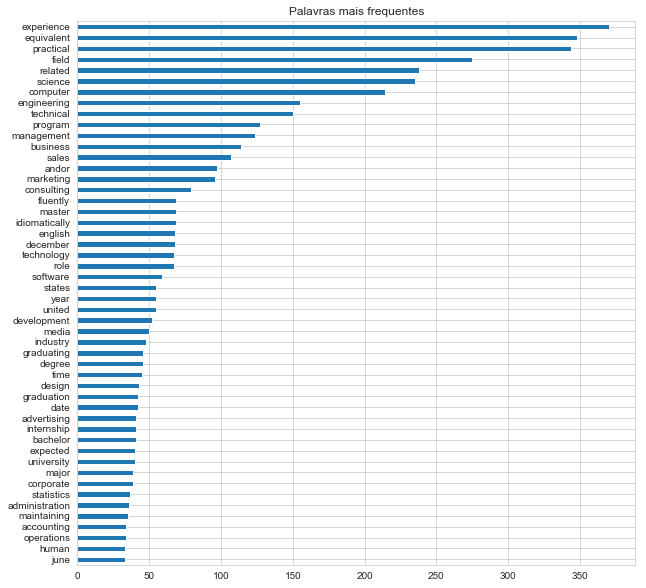

In [88]:
corpus = []

corpus = list(df['MQ_field'].dropna().values)

def removeStuff(string):
    import re # pacote para executar regex
    pattern = [
    r"[.%!+;={}():/\[\]\@\?\"]",   #remove pontuação
    r"\d*",          #remove números (vamos eliminá-los em uma primeira análise)
    r"\b[a-z]\b",    #remove caracteres únicos
    ]  
    for x in pattern:
        string = re.sub(x, '', string)
    return string

corpus = [removeStuff(string) for string in corpus]


list_stop_words = list(stop_words.ENGLISH_STOP_WORDS)

vectorizer = CountVectorizer()
freq = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

FreqPalavras = pd.DataFrame(freq.toarray(), columns=vectorizer.get_feature_names())

retirar = [word for word in list_stop_words if word in list(vectorizer.get_feature_names())]

plt.figure(figsize=(10,10))
plt.title('Palavras mais frequentes')
FreqPalavras.drop(columns=retirar).sum().sort_values(ascending=False)[0:50].sort_values(ascending=True).plot(kind='barh');

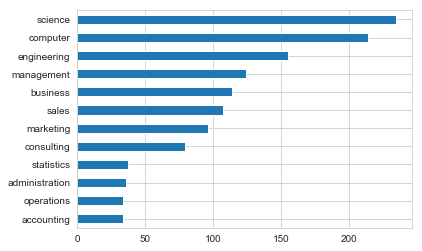

In [89]:
FreqPalavras[['science', 'computer','engineering', 'management','business', 'sales', 'marketing', 'consulting', 'statistics', 'administration', 'accounting', 'operations']].sum().sort_values(ascending=True).plot(kind='barh')

['advertising', 'an', 'and', 'any', 'area', 'at', 'brazil', 'brazilian', 'business', 'computer', 'date', 'december', 'development', 'english', 'equivalent', 'expected', 'experience', 'field', 'firm', 'fluently', 'for', 'graduation', 'hr', 'idiomatically', 'in', 'line', 'major', 'management', 'marketing', 'media', 'of', 'online', 'operations', 'or', 'portuguese', 'practical', 'programevent', 'recruiting', 'related', 'relations', 'role', 'sales', 'science', 'similar', 'spanish', 'strategy', 'study', 'technical', 'technology', 'university', 'with']


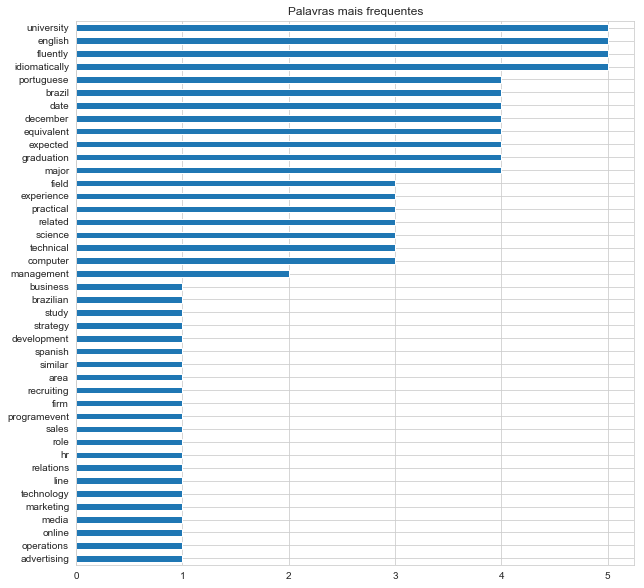

In [90]:
#Para o caso do Brasil

corpus = []

corpus = list(df[df['Countries']=='Brazil']['MQ_field'].dropna().values)

def removeStuff(string):
    import re # pacote para executar regex
    pattern = [
    r"[.%!+;={}():/\[\]\@\?\"]",   #remove pontuação
    r"\d*",          #remove números (vamos eliminá-los em uma primeira análise)
    r"\b[a-z]\b",    #remove caracteres únicos
    ]  
    for x in pattern:
        string = re.sub(x, '', string)
    return string

corpus = [removeStuff(string) for string in corpus]


list_stop_words = list(stop_words.ENGLISH_STOP_WORDS)

vectorizer = CountVectorizer()
freq = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

FreqPalavras = pd.DataFrame(freq.toarray(), columns=vectorizer.get_feature_names())

retirar = [word for word in list_stop_words if word in list(vectorizer.get_feature_names())]

plt.figure(figsize=(10,10))
plt.title('Palavras mais frequentes')
FreqPalavras.drop(columns=retirar).sum().sort_values(ascending=True).plot(kind='barh')

In [91]:
df[df['Countries']=='Brazil'].shape[0]

15

In [92]:
# Sobre vagas idênticas:

In [93]:
df[df.duplicated()]

Company                                              Title  \
304    Google                    Data Analyst, Consumer Hardware   
305    Google              Partner Onboarding Manager (Americas)   
308    Google                  Survey Lead, Google Cloud Support   
316    Google                  Quantitative Analyst, Ads Quality   
318    Google                      Head of Professional Services   
323    Google                  Survey Lead, Google Cloud Support   
333    Google  Solutions Consultant, Ads, Google Professional...   
355    Google              Partner Onboarding Manager (Americas)   
367    Google  Solutions Consultant, Ads, Google Professional...   
374    Google       Partner Sales Engineer Manager, Google Cloud   
379    Google        Quantitative Analyst Lead, Trust and Safety   
398    Google                   Product Specialist, Google Cloud   
412    Google  Cloud Consultant, Professional Services, Googl...   
417    Google  Process Specialist, Curated Formats, Google Te...   
443    Google  Linguist, Natural Language Understanding, Mach...   
461    Google       Partner Strategy Planning Lead, Google Cloud   
465    Google  Partner Operations Manager, Commerce, Google T...   
466   YouTube                Product Strategist, Growth, YouTube   
487    Google  Global Technical Alliance Manager, Strategic C...   
489    Google             Quantitative Analyst, Trust and Safety   
508    Google  Strategic Cloud DevOps and Infrastructure Engi...   
510    Google  Program Manager, Cloud Platform Sales Developm...   
511    Google                         Store Operations Associate   
519    Google              Partner Onboarding Manager (Americas)   
567    Google    Head of Professional Services (English, French)   
591    Google  Technical Solutions Consultant, Android Automo...   
631    Google         MBA Intern (Korean-English Bilingual) 2018   
697    Google  Communications and Programs Manager, Google Te...   
708    Google  Program Manager/Producer, Global Hardware Mark...   
711    Google  Technical Analytics Architect, Google Cloud On...   
...       ...                                                ...   
1114   Google                                    MBA Intern 2018   
1116   Google                            MBA Intern, Summer 2018   
1124   Google                            MBA Intern, Summer 2018   
1125   Google                            MBA Intern, Summer 2018   
1131   Google                           BOLD Intern, Summer 2018   
1135   Google                       Business Intern 2018, Mexico   
1136   Google                     Business Intern 2018, Colombia   
1142   Google                           BOLD Intern, Summer 2018   
1143   Google                    Business Intern 2017, Australia   
1147   Google                                    MBA Intern 2018   
1153   Google                            MBA Intern, Summer 2018   
1154   Google                                    MBA Intern 2018   
1165   Google                           BOLD Intern, Summer 2018   
1166   Google                                    MBA Intern 2018   
1168  YouTube                Product Strategist, Growth, YouTube   
1173   Google                           BOLD Intern, Summer 2018   
1184   Google                    Internal Communications Manager   
1187   Google                           BOLD Intern, Summer 2018   
1191   Google                       Business Intern 2018, Brazil   
1194   Google                            MBA Intern, Summer 2018   
1198   Google                    Internal Communications Manager   
1204   Google                            MBA Intern, Summer 2018   
1205   Google                                    MBA Intern 2018   
1213   Google                    Business Intern 2018, Argentina   
1217   Google                            MBA Intern, Summer 2018   
1219   Google                                    MBA Intern 2018   
1221   Google         Live Show Producer, Events and Experienc

In [94]:
df[df.duplicated()].shape[0]

123

In [95]:
def cloud_from_column(column):
    corpus1 = list(column.dropna().values)

    text=''
    for string in corpus1:
        text = text + ' ' + string

    wordcloud = WordCloud().generate(text)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

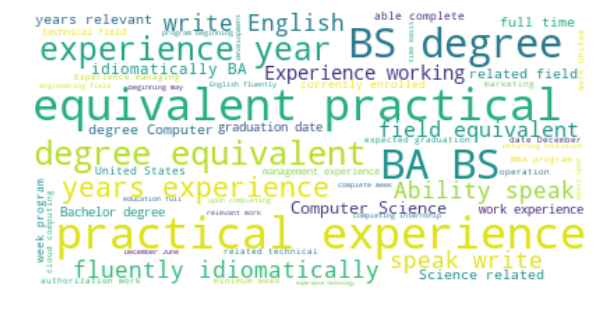

In [96]:
corpus1 = list(df['Minimum Qualifications'].dropna().values)

text=''
for string in corpus1:
    text = text + ' ' + string

wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

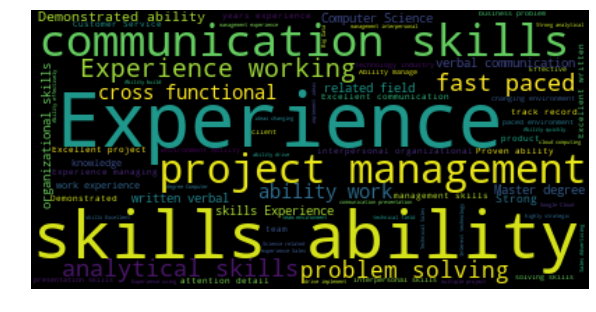

In [97]:
corpus2 = list(df['Preferred Qualifications'].dropna().values)

text2=''
for string in corpus2:
    text2 = text2 + ' ' + string

wordcloud = WordCloud().generate(text2)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

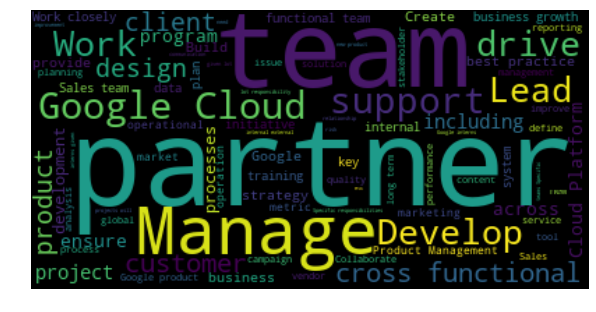

In [98]:
corpus3 = list(df['Responsibilities'].dropna().values)

text3=''
for string in corpus3:
    text3 = text3 + ' ' + string

wordcloud = WordCloud().generate(text3)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

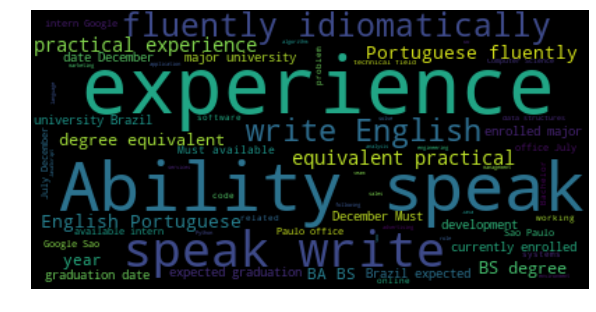

In [99]:
cloud_from_column(df[df['Countries']=='Brazil']['Minimum Qualifications'])


Referência para wordcloud: https://www.datacamp.com/community/tutorials/wordcloud-python

Referência para sistemas de recomandação: http://coral.ufsm.br/pet-si/index.php/sistemas-de-recomendacao-desvendando-uma-parte-da-magica/

Sobre clusterização: https://lamfo-unb.github.io/2017/10/05/Introducao_basica_a_clusterizacao/

In [100]:
# Verificar também outros conhecimentos técnicos: Unix, linux, codec, etc. Verificar outras ferramentas de cada área.

# Criar uma Cloud para cada categoria.


In [101]:
# Se meu amigo quer muito trabalhar no google a primeira pergunta é: 
# Ele está com pressa e quer entrar onde der ou
# ele tem tempo de se preparar e sabe em que setor quer atuar? 
# E a segunda é: Qual o nível de experiência que ele já tem? 
# Se ele tem pressa, a maior parte das vagas que não exigem anos de experiência estão nos setores: ______
# mesmo assim, ele muito provavelmente vai precisar de ao menos um bacharelado.

# Agora, se ele tem tempo de adquirir experiência e quer direcionar o que ele deve dominar,
# temos que ter em mente quais os conhecimentos necessários em cada setor.

In [102]:
# Sobre o sistema de recomendação: abrir nas ferramentas e coisas que devem ser dominadas em cada setor.